# IMPORTS

In [2]:
# IMPORTS
import numpy as np
import random
import itertools
import json
import os
# Machine Learning imports
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import PReLU, Input, LSTM, Flatten, Concatenate, Dense, Conv2D, TimeDistributed, MaxPooling2D, ReLU, Dropout, BatchNormalization, Activation, Reshape
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Precision
from tensorflow.keras import backend as K
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.callbacks import TensorBoard
import tensorflow_model_optimization
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks
print("tensorflow version:", tf.__version__)
import keras
print("keras version:",keras.__version__)
import qkeras
from qkeras import QActivation, QDense, QConv2D, QBatchNormalization, QConv2DBatchnorm
from qkeras import quantized_relu, quantized_bits
from qkeras.utils import _add_supported_quantized_objects
from qkeras.autoqkeras.utils import print_qmodel_summary
print("qkeras version:",keras.__version__)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
# Display and plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from IPython.display import HTML, display
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import confusion_matrix
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
from scipy import stats
# Data management
import psutil
import h5py
# Memory management
import gc
# Notifications
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from dotenv import load_dotenv
load_dotenv()
def send_email_notification(subject, content):
    sender_email = os.getenv('EMAIL_USER')
    receiver_email = "alexander.j.yue@gmail.com"
    password = os.getenv('EMAIL_PASS')

    message = MIMEMultipart()
    message["From"] = sender_email
    message["To"] = receiver_email
    message["Subject"] = subject
    body = content
    message.attach(MIMEText(body, "plain"))

    with smtplib.SMTP("smtp.gmail.com", 587) as server:
        server.starttls()
        server.login(sender_email, password)
        server.sendmail(sender_email, receiver_email, message.as_string())

# Memory monitoring functions
def print_memory_usage():
    memory = psutil.virtual_memory()
    print(f"Total memory: {memory.total / (1024**3):.2f} GB")
    print(f"Available memory: {memory.available / (1024**3):.2f} GB")
    print(f"Used memory: {memory.used / (1024**3):.2f} GB")
    print(f"Memory usage percentage: {memory.percent}%")

def print_cpu_usage():
    cpu_percent = psutil.cpu_percent(interval=1)
    print(f"CPU Usage: {cpu_percent}%")

2024-08-23 17:12:16.947537: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-23 17:12:17.028027: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-23 17:12:17.029096: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-23 17:12:19.285845: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


tensorflow version: 2.13.1
keras version: 2.13.1
qkeras version: 2.13.1


# Dataset

In [3]:
# Load the pixel cluster to transverse momentum dataset into the input_data and target_data
def load_combine_shuffle_data_optimized_hdf5():
    # Load the dataset from Kenny's computer
    with h5py.File('/fs/ddn/sdf/group/atlas/d/hjia625/Smart_Pixel/fl32_data_v3.hdf5', 'r') as h5f:
        combined_input = None
        combined_target = None

        for data_type in ['sig', 'bkg']:
            # Construct dataset names
            input_dataset_name = f'{data_type}_input'
            target_dataset_name = f'{data_type}_target'

            # Check if the dataset exists and load data sequentially
            if input_dataset_name in h5f and target_dataset_name in h5f:
                input_data = h5f[input_dataset_name][:].astype(np.float32)
                target_data = h5f[target_dataset_name][:].astype(np.float32)

                if combined_input is None:
                    combined_input = input_data
                    combined_target = target_data
                    # Free memory of the loaded data
                    del input_data, target_data
                    gc.collect()

                else:
                    print_memory_usage()
                    combined_input = np.vstack((combined_input, input_data))
                    combined_target = np.vstack((combined_target, target_data))
                    # Free memory of the loaded data
                    del input_data, target_data
                    gc.collect()

            else:
                print(f"Dataset {input_dataset_name} or {target_dataset_name} not found.")

        # Shuffling
        indices = np.arange(combined_input.shape[0])
        np.random.shuffle(indices)
        combined_input = combined_input[indices]
        combined_target = combined_target[indices]

        return combined_input, combined_target

In [4]:
def load_dataset():
    # Load dataset into memory
    input_data, target_data = load_combine_shuffle_data_optimized_hdf5()
    # Format the dataset into a 20x13x21 tensor (time, y, x)
    input_data = input_data.reshape(input_data.shape[0],20,13,21)
    global_max = np.max(input_data)
    global_min = np.min(input_data)
    print(f"max: {global_max}, min: {global_min}")
    return input_data, target_data, global_min, global_max

def process_dataset(input_data, target_data, hyperparams, global_min, global_max):
    NUM_TIME_SLICES = hyperparams["NUM_TIME_SLICES"]
    MODEL_TYPE = hyperparams["MODEL_TYPE"]
    TRAIN_PT_THRESHOLD = hyperparams["TRAIN_PT_THRESHOLD"]
    TEST_PT_THRESHOLD = hyperparams["TEST_PT_THRESHOLD"]
    OUTPUT = hyperparams["OUTPUT"]
    INPUT_SCALING = hyperparams["INPUT_SCALING"]
    IO_BITS = hyperparams["IO_BITS"]
    Y0_SCALING = hyperparams["Y0_SCALING"]
    INCLUDE_X = hyperparams["INCLUDE_X"]

    # Split 80% of data into training data, 10% for validation data and 10% for testing data
    input_train_data, input_temp, target_train_data, target_temp = \
    train_test_split(input_data, target_data, test_size=0.2, random_state=42)
    del input_data
    del target_data
    gc.collect()
    input_validate_data, input_test_data, target_validate_data, target_test_data = \
    train_test_split(input_temp, target_temp, test_size=0.5, random_state=42)
    del input_temp
    del target_temp
    gc.collect()

    # Save all test data for displaying
    input_data_example = input_test_data
    target_data_example = target_test_data

    # Initiate the scalers on the training data 
    if INPUT_SCALING == "Standard":
        input_scaler = StandardScaler()
        input_scaler.fit(input_train_data[:, :NUM_TIME_SLICES, :, :].reshape(-1,NUM_TIME_SLICES*13))
    if Y0_SCALING == "Standard":
        y0_scaler = StandardScaler()
        y0_scaler.fit(target_train_data[:,7].reshape(-1, 1))
    if INPUT_SCALING == "MinMax":
        input_scaler = MinMaxScaler()
        input_scaler.fit(input_train_data[:, :NUM_TIME_SLICES, :, :].reshape(-1,NUM_TIME_SLICES*13))
    if Y0_SCALING == "MinMax":
        y0_scaler = MinMaxScaler()
        y0_scaler.fit(target_train_data[:,7].reshape(-1, 1))

    # Process the data into input shape and labels for training
    def process_data(input_data, target_data, pt_threshold):
        if input_data.shape[1:] == (20, 13, 21) and target_data.shape[1:] == (13, ):

            # Truncate down to first time slices
            input_data = input_data[:, :NUM_TIME_SLICES, :, :]

            # sum over the x axis to turn the input data into a 2D NUM_TIME_SLICES x 13 tensor (time, y)
            if not INCLUDE_X:
                input_data = np.sum(input_data, axis=3)

            if OUTPUT == "SOFTMAX" or OUTPUT == "LINEAR":
                # Encode the target data into one_hot encoding
                one_hot = np.zeros((target_data.shape[0], 3))
                # Assign 1 for p_t > pt_threshold in GeV, for low p_t put 1 in slot 2 for negative and a 1 in slot 3 for positive
                one_hot[np.abs(target_data[:, 8]) >= pt_threshold, 0] = 1
                one_hot[(np.abs(target_data[:, 8]) < pt_threshold) & (target_data[:, 8] > 0), 1] = 1
                one_hot[(np.abs(target_data[:, 8]) < pt_threshold) & (target_data[:, 8] < 0), 2] = 1
                label_data = one_hot
            # elif OUTPUT == "ARGMAX": # DOES NOT WORK 
            #     label_data = np.argmax(one_hot, axis=1).astype(np.int64)
            #     print("one hot is ", one_hot)
            elif OUTPUT == "SINGLE":
            # Binary labels for 0th category
                label_data = (np.abs(target_data[:, 8]) >= pt_threshold).astype(np.int64)
            elif OUTPUT == "REGRESS":
                # Encode the target data
                # 0 x-entry is generally from -400 to 400 (Gaussian)
                # 1 y-entry is generally from -30 to 30 (Gaussian)
                # 8 p_t is generally from -5 to 5 (Strange distribution)
                # 9 cotAlpha is clamped between -8 and 8 (Gaussian with cutoff)
                # 10 cotBeta is generally between -0.4 and 0.4 (Gaussian)
                encoding = np.column_stack((
                    target_data[:, 8] / 5, 
                    target_data[:, 0] / 400, 
                    target_data[:, 1] / 30, 
                    target_data[:, 9] / 8, 
                    target_data[:, 10] / 0.4,
                ))
                # now is (p_t, x-entry, y-entry, cotAlpha, cotBeta)
                label_data = encoding

            # Flatten the input data
            if INCLUDE_X:
                input_data = input_data.reshape(-1,NUM_TIME_SLICES*13*21)
            else: 
                input_data = input_data.reshape(-1,NUM_TIME_SLICES*13)

            # Get the y_0 data
            y0_data = target_data[:,7].reshape(-1, 1)

            # Normalize the input data according to scaling method
            if INPUT_SCALING == "Standard" or INPUT_SCALING == "MinMax":
                input_data = input_scaler.transform(input_data)
            elif INPUT_SCALING == "Log":
                # Replace all values < 1 with 1 so they log to 0
                input_data = np.where(np.abs(input_data) < 1.0, 1.0, input_data)
                # Apply logarithmic scaling
                input_data = np.log(np.abs(input_data)) * np.sign(input_data)
                # Min-max normalization (global)
                global_log_min = np.log(np.abs(global_min)) * np.sign(global_min)
                global_log_max = np.log(np.abs(global_max)) * np.sign(global_max)
                input_data = (input_data) / global_log_max
                # Take square root of abs to better distribute it
                input_data = np.square(np.abs(input_data)) * np.sign(input_data)
            elif INPUT_SCALING == "Quantized":
                if (IO_BITS == 2):
                    bin_edges = [-np.inf, 400, 1600, 2400, np.inf]
                    bin_values = [-1.0, -0.5, 0.0, 0.5]
                else:
                    num_bins = 2**IO_BITS
                    bin_values = np.linspace(-1, 1 - 2/num_bins, num_bins)
                    
                    max_edge = 1600 + 400 * IO_BITS
                    non_inf_edges = np.linspace(0, max_edge, num_bins)[1:]
                    
                    bin_edges = np.concatenate([[-np.inf], non_inf_edges, [np.inf]])
                
                for i, edge in enumerate(bin_edges[1:]):
                    input_data[(input_data >= bin_edges[i]) & (input_data < edge)] = bin_values[i]
                input_data[input_data >= bin_edges[-1]] = bin_values[-1]
            elif INPUT_SCALING == "None":
                print("NO INPUT SCALING")
            else:
                raise ValueError(f"scaling input by {INPUT_SCALING} not supported yet")
                
            if Y0_SCALING == "Standard" or Y0_SCALING == "MinMax":
                y0_data = y0_scaler.transform(y0_data)
            elif Y0_SCALING == "Linear":
                y0_data = y0_data / 8
            elif Y0_SCALING == "None":
                print("NO Y0_SCALING")
            else:
                raise ValueError(f"scaling y0 by {Y0_SCALING} not supported yet")

            
            # Combine with input data
            if (MODEL_TYPE == "DNN" or MODEL_TYPE == "AE"):
                # For DNN we concatenate in the y_0 data
                input_data_combined = np.hstack((input_data, y0_data))
            elif (MODEL_TYPE == "CNN"):
                # Reshape data into a matrix for the convolutions
                input_data = input_data.reshape(-1, NUM_TIME_SLICES, 13)
                # Package with the y_0 data to be added later
                input_data_combined = [input_data, y0_data]
            else: 
                raise ValueError(f"unsupported MODEL_TYPE {MODEL_TYPE}") 
            
            return input_data_combined, label_data
        else:
            raise ValueError("Wrong array shape!")

    # Apply data processing to our datasets
    input_train_data_combined, target_train_data_coded = process_data(input_train_data, target_train_data, TRAIN_PT_THRESHOLD)
    input_validate_data_combined, target_validate_data_coded = process_data(input_validate_data, target_validate_data, TRAIN_PT_THRESHOLD)
    input_test_data_combined, target_test_data_coded = process_data(input_test_data, target_test_data, TEST_PT_THRESHOLD)

    # Save all test data for displaying
    if MODEL_TYPE == "DNN" or MODEL_TYPE == "AE":
        input_data_combined_example = input_test_data_combined
        target_data_coded_example = target_test_data_coded
    elif MODEL_TYPE == "CNN":
        input_data_combined_example = np.hstack((input_test_data_combined[0].reshape(100, -1), input_test_data_combined[1]))
        target_data_coded_example = target_test_data_coded
    else:
        raise ValueError("Invalid model type")

    print_memory_usage()
    max_input_test = np.max(input_test_data_combined)
    min_input_test = np.min(input_test_data_combined)

    processed_dataset = {
        "input_train_data_combined": input_train_data_combined,
        "target_train_data_coded": target_train_data_coded,
        "input_validate_data_combined": input_validate_data_combined,
        "target_validate_data_coded": target_validate_data_coded,
        "input_test_data_combined": input_test_data_combined,
        "target_test_data_coded": target_test_data_coded,

        "input_data_example": input_data_example,
        "target_data_example": target_data_example,
        "input_data_combined_example": input_data_combined_example,
        "target_data_coded_example": target_data_coded_example,

        "max_input_test": max_input_test,
        "min_input_test": min_input_test,
    }

    return processed_dataset 

def encode_data(input_data, encoder, hyperparams):
    ENCODER_TIME_SLICES = hyperparams["ENCODER_TIME_SLICES"]

    input_test_data_combined_truncated =  np.concatenate([input_data[:, :ENCODER_TIME_SLICES*13], input_data[:, -1:]], axis=1)

    predictions = encoder.predict(input_test_data_combined_truncated)
    print(f"predictions shape is {predictions.shape}")
    return predictions

def recreate_data(input_data, autoencoder, hyperparams):
    ENCODER_TIME_SLICES = hyperparams["ENCODER_TIME_SLICES"]

    input_test_data_combined_truncated =  np.concatenate([input_data[:, :ENCODER_TIME_SLICES*13], input_data[:, -1:]], axis=1)

    predictions = autoencoder.predict(input_test_data_combined_truncated)
    print(f"predictions shape is {predictions.shape}")
    return predictions

def mask_data(input_data, hyperparams):
    ENCODER_TIME_SLICES = hyperparams["ENCODER_TIME_SLICES"]

    input_test_data_combined_truncated =  np.concatenate([input_data[:, :ENCODER_TIME_SLICES*13], input_data[:, -1:]], axis=1)
    input_test_data_grid = input_test_data_combined_truncated[:, :ENCODER_TIME_SLICES*13].reshape(-1, ENCODER_TIME_SLICES, 13)
    for i in range(input_test_data_grid.shape[0]):
        rand_idx = random.randint(0, 130) # mask about one in 10 events
        if (rand_idx < 13):
            input_test_data_grid[i, :, rand_idx] = 0.0
    
    input_test_data_flat = input_test_data_grid.reshape(-1, ENCODER_TIME_SLICES*13)
    input_test_data_masked = np.concatenate([input_test_data_flat, input_test_data_combined_truncated[:, -1:]], axis=1)
    return input_test_data_masked


# Machine Learning

In [5]:
# Defining the model
from tensorflow.keras.layers import Layer
import tensorflow as tf

class ArgmaxLayer(Layer):
    def __init__(self, **kwargs):
        super(ArgmaxLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.cast(tf.argmax(inputs, axis=-1), dtype=tf.int64)

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(ArgmaxLayer, self).get_config()
        return config
    
def qDNNmodel(hyperparams):
    NUM_TIME_SLICES = hyperparams["NUM_TIME_SLICES"]
    ENCODING_NODES = hyperparams["ENCODING_NODES"]
    DNN_LAYERS = hyperparams["DNN_LAYERS"]
    WEIGHTS_BITS = hyperparams["QUANTIZATION_BITS"][0]
    BIAS_BITS = hyperparams["QUANTIZATION_BITS"][0]
    ACTIVATION_BITS = hyperparams["QUANTIZATION_BITS"][1]
    INTEGER_BITS = hyperparams["QUANTIZATION_BITS"][2]
    LEARNING_RATE = hyperparams["LEARNING_RATE"]
    OUTPUT = hyperparams["OUTPUT"]
    INCLUDE_X = hyperparams["INCLUDE_X"]

    if INCLUDE_X:
        if ENCODING_NODES == "None" or ENCODING_NODES == "Recreated":
            y_timed_input = Input(shape=(NUM_TIME_SLICES*13*21 + 1,), name='y_timed_input')
        else: 
            y_timed_input = Input(shape=(ENCODING_NODES,), name='y_timed_input')
    else:
        if ENCODING_NODES == "None" or ENCODING_NODES == "Recreated":
            y_timed_input = Input(shape=(NUM_TIME_SLICES*13 + 1,), name='y_timed_input')
        else: 
            y_timed_input = Input(shape=(ENCODING_NODES,), name='y_timed_input')

    layer = y_timed_input
    
    for i, size in enumerate(DNN_LAYERS):
        layer = QDense(
            size, 
            kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0), 
            bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), 
            name=f'dense{i+1}')(layer)
        layer = BatchNormalization(name=f'batch_norm{i+1}')(layer)
        layer = QActivation(quantized_relu(ACTIVATION_BITS),name=f'relu{i+1}')(layer)

    if OUTPUT == "SOFTMAX":
        output = QDense(3, 
        kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0), 
        bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), 
        name='dense_output')(layer)
        output = Activation("softmax", name='output_softmax')(output)
    elif OUTPUT == "ARGMAX":
        output = QDense(3, 
        kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0), 
        bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0),
        name='dense_output')(layer)
        output = ArgmaxLayer(name='output_argmax')(output)
        print(f"Argmax output dtype: {output.dtype}")
    elif OUTPUT == "LINEAR":
        output = QDense(3, 
        kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0), 
        bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0),
        name='dense_output')(layer)
    elif OUTPUT == "SINGLE":
        output = QDense(1, 
        kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0), 
        bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0),
        name='dense_output')(layer)
    elif OUTPUT == "REGRESS":
        output = QDense(5, 
        kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0), 
        bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0),
        name='dense_output')(layer)
    else:
        raise ValueError("Not a supported output type")
   
    model = Model(inputs=y_timed_input, outputs=output)

    if OUTPUT == "SOFTMAX":
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), 
            loss='categorical_crossentropy', 
            metrics=[Precision()])
    elif OUTPUT == "ARGMAX":
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), 
            loss='sparse_categorical_crossentropy', 
            metrics=[Precision()])
    elif OUTPUT == "LINEAR" or OUTPUT == "REGRESS":
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), 
            loss='mean_squared_error', 
            metrics=[mae, rmse, r_squared])
    elif OUTPUT == "SINGLE":
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
            loss='binary_crossentropy',
            metrics=['accuracy'])
    return model


def qCNNmodel(hyperparams):
    NUM_TIME_SLICES = hyperparams["NUM_TIME_SLICES"]
    CONV_LAYER_DEPTHS = hyperparams["CONV_LAYER_DEPTHS"]
    CONV_LAYER_KERNELS = hyperparams["CONV_LAYER_KERNELS"]
    CONV_LAYER_STRIDES = hyperparams["CONV_LAYER_STRIDES"]
    MAX_POOLING_SIZE = hyperparams["MAX_POOLING_SIZE"]
    FLATTENED_LAYERS = hyperparams["FLATTENED_LAYERS"]
    WEIGHTS_BITS = hyperparams["QUANTIZATION_BITS"][0]
    BIAS_BITS = hyperparams["QUANTIZATION_BITS"][0]
    INTEGER_BITS = hyperparams["QUANTIZATION_BITS"][2]
    ACTIVATION_BITS = hyperparams["QUANTIZATION_BITS"][1]
    LEARNING_RATE = hyperparams["LEARNING_RATE"]

    y_profile_input = Input(shape=(NUM_TIME_SLICES, 13, 1), name='y_profile_input')  # Adjust the shape based on your input
    layer = y_profile_input

    # Convolutional layers
    for i in range(len(CONV_LAYER_DEPTHS)):
        layer = QConv2D(
        CONV_LAYER_DEPTHS[i],
        kernel_size=CONV_LAYER_KERNELS[i],
        strides=CONV_LAYER_STRIDES[i],
        kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0),
        bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0),
        padding='same',
        use_bias=True,
        name=f'conv{i+1}'
        )(layer)
        layer = QActivation(quantized_relu(ACTIVATION_BITS), name=f'relu{i+1}')(layer)
        layer = MaxPooling2D(pool_size=MAX_POOLING_SIZE, name=f'maxpool{i+1}')(layer)

    # Flatten the output to feed into a dense layer
    layer = Flatten(name='flattened')(layer)

    # Flatten and concatenate with y0 input
    y0_input = Input(shape=(1,), name='y0_input')
    layer = Concatenate(name='concat')([layer, y0_input])

    # Post-flattening dense layers
    for i in range(len(FLATTENED_LAYERS)):
        layer = QDense(FLATTENED_LAYERS[i], kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0),
                    bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), name=f'dense{i+1}')(layer)
        layer = QActivation(quantized_relu(10), name=f'relu{len(CONV_LAYER_DEPTHS)+i+1}')(layer)

    # Output layer (adjust based on your classification problem)
    output = QDense(3, kernel_quantizer=quantized_bits(WEIGHTS_BITS), bias_quantizer=quantized_bits(BIAS_BITS), name='dense_output')(layer)
    output = Activation("softmax", name='output_softmax')(output)
    # layer = QDense(1, kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0), 
    #                bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), name='output_dense')(layer)
    # output = Activation("sigmoid", name='output_sigmoid')(layer)

    model = Model(inputs=[y_profile_input, y0_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy']) # loss='binary_crossentropy'

    return model

def mae(y_true, y_pred): # Mean absolute error
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def rmse(y_true, y_pred): # room mean squared error
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def r_squared(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return (1 - SS_res / (SS_tot + tf.keras.backend.epsilon()))

def qAEmodel(hyperparams):
    NUM_TIME_SLICES = hyperparams["NUM_TIME_SLICES"]
    ENCODER_TIME_SLICES = hyperparams["ENCODER_TIME_SLICES"]
    ENCODER_LAYERS = hyperparams["ENCODER_LAYERS"]
    DECODER_LAYERS = hyperparams["DECODER_LAYERS"]
    WEIGHTS_BITS = hyperparams["QUANTIZATION_BITS"][0]
    BIAS_BITS = hyperparams["QUANTIZATION_BITS"][0]
    INTEGER_BITS = hyperparams["QUANTIZATION_BITS"][2]
    ACTIVATION_BITS = hyperparams["QUANTIZATION_BITS"][1]
    LEARNING_RATE = hyperparams["LEARNING_RATE"]


    y_timed_input = Input(shape=(ENCODER_TIME_SLICES*13 + 1,), name='y_timed_input')
    layer = y_timed_input

    layer = Flatten(name='flatten_input')(layer)

    all_layer_specs = ENCODER_LAYERS + DECODER_LAYERS
    # Add encoder and decoder layers
    for i in range(len(all_layer_specs)):
        layer_specs = all_layer_specs[i]

        if isinstance(layer_specs, int):
            layer_name = f'dense{i+1}'
            if (i == len(ENCODER_LAYERS) - 1):
                layer_name = 'latent_space'
            layer = QDense(layer_specs, kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0),
                    bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), name=layer_name)(layer)
            layer = QActivation(quantized_relu(ACTIVATION_BITS), name=f'relu{i+1}')(layer)
            layer = BatchNormalization(name=f'batch_norm{i+1}')(layer)
        else:
            raise ValueError(f"Unsupported layer specification: {layer_specs}")
        
    # output layer
    layer = QDense(NUM_TIME_SLICES*13 + 1, kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0),
            bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), name="output")(layer)
    layer = QActivation(quantized_relu(ACTIVATION_BITS), name=f'output_relu')(layer)
    layer = BatchNormalization(name=f'output_batch_norm')(layer)
    
    model = Model(inputs=y_timed_input, outputs=layer)
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mean_squared_error', metrics=[mae, rmse, r_squared]) 

    return model


# Pruning the model
def pruneFunction(layer, train_data_size, hyperparams):
    BATCH_SIZE = hyperparams["BATCH_SIZE"]
    FINAL_SPARSITY = hyperparams["FINAL_SPARSITY"]
    PRUNE_START_EPOCH = hyperparams["PRUNE_START_EPOCH"]
    NUM_PRUNE_EPOCHS = hyperparams["NUM_PRUNE_EPOCHS"]

    steps_per_epoch = train_data_size // BATCH_SIZE #input_train_data_combined.shape[0]
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=0.0,
            final_sparsity=FINAL_SPARSITY,
            begin_step=steps_per_epoch * PRUNE_START_EPOCH,
            end_step=steps_per_epoch * (PRUNE_START_EPOCH + NUM_PRUNE_EPOCHS),
            frequency=steps_per_epoch # prune after every epoch
        )
    }


    if isinstance(layer, QDense):
        if layer.name != 'output_softmax' and layer.name != 'dense2':
            print(f"pruning layer {layer.name}")
            return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
        elif layer.name != 'output_softmax' and layer.name != 'dense1':
            print(f"pruning layer {layer.name}")
            return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
        else:
            print(f"cannot prune layer {layer.name}")
            return layer

    else:
        print(f"cannot prune layer {layer.name}")
        return layer
    
def pruneFunctionWrapper(train_data_size, hyperparams):
    def wrapper(layer):
        return pruneFunction(layer, train_data_size, hyperparams)
    return wrapper
    

# Function to calculate sparsity
def calculate_sparsity(model):
    total_params = 0
    zero_params = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            weights = layer.get_weights()[0]
            total_params += weights.size
            zero_params += np.sum(weights == 0)
    sparsity = zero_params / total_params
    return sparsity

In [6]:
def train_model(data, hyperparams):
    MODEL_TYPE = hyperparams["MODEL_TYPE"]
    ENCODER_TIME_SLICES = hyperparams["ENCODER_TIME_SLICES"]
    PATIENCE = hyperparams["PATIENCE"]
    EPOCHS = hyperparams["EPOCHS"]
    BATCH_SIZE = hyperparams["BATCH_SIZE"]
    LEARNING_RATE = hyperparams["LEARNING_RATE"]
    POST_PRUNE_EPOCHS = hyperparams["POST_PRUNE_EPOCHS"]
    ENCODING_NODES = hyperparams["ENCODING_NODES"]
    OUTPUT = hyperparams["OUTPUT"]

    if ENCODING_NODES == "None":
        print("Using default input")
        input_train_data_combined = data["input_train_data_combined"]
        input_validate_data_combined = data["input_validate_data_combined"]
    elif ENCODING_NODES == "Recreated":
        input_train_data_combined = data["input_train_data_recreated"]
        input_validate_data_combined = data["input_validate_data_recreated"]
        print (input_train_data_combined.shape)
        print (input_validate_data_combined.shape)
    else:
        input_train_data_combined = data["input_train_data_encoded"]
        input_validate_data_combined = data["input_validate_data_encoded"]
        print (input_train_data_combined.shape)
        print (input_validate_data_combined.shape)
    
    target_train_data_coded = data["target_train_data_coded"]
    target_validate_data_coded = data["target_validate_data_coded"]


    
    # Define the model
    if (MODEL_TYPE == "DNN"):
        model = qDNNmodel(hyperparams)
    elif (MODEL_TYPE == "CNN"):
        model = qCNNmodel(hyperparams)
    elif (MODEL_TYPE == "AE"):
        model = qAEmodel(hyperparams)
    else:
        raise ValueError("Not a supported model type")

    model.summary()
    print_qmodel_summary(model)
    print(f"Initial Sparsity: {calculate_sparsity(model) * 100:.2f}%")

    train_metrics = {}

    # Train the model
    earlyStop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=PATIENCE, restore_best_weights=True)
    tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)
    if MODEL_TYPE == "DNN" or MODEL_TYPE == "CNN":
        history = model.fit(
            input_train_data_combined, target_train_data_coded,  # Training data and labels
            validation_data=(input_validate_data_combined, target_validate_data_coded),  # Validation data
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=[earlyStop_callback] # , tensorboard_callback
        )
    elif (MODEL_TYPE == "AE"):
        input_train_data_combined_truncated =  np.concatenate([input_train_data_combined[:, :ENCODER_TIME_SLICES*13], input_train_data_combined[:, -1:]], axis=1)
        input_validate_data_combined_truncated =  np.concatenate([input_validate_data_combined[:, :ENCODER_TIME_SLICES*13], input_validate_data_combined[:, -1:]], axis=1)
        history = model.fit(
            input_train_data_combined_truncated, input_train_data_combined,  # Training data as input and the output
            validation_data=(input_validate_data_combined_truncated, input_validate_data_combined),  # Validation data
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=[earlyStop_callback] # , tensorboard_callback
        )
    else:
        raise ValueError("Not a supported model type")

    # Save the val_loss
    train_metrics["val_loss"] = history.history['val_loss'][-1]

   # Prune the model
    model_pruned = keras.models.clone_model(model, clone_function=pruneFunctionWrapper(input_train_data_combined.shape[0], hyperparams))

    if MODEL_TYPE == "DNN" or MODEL_TYPE == "CNN":
        if OUTPUT != "REGRESS":
            model_pruned.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])
        else:
            model_pruned.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mean_squared_error', metrics=[mae, rmse, r_squared])
        history = model_pruned.fit(
            input_train_data_combined, target_train_data_coded,
            validation_data=(input_validate_data_combined, target_validate_data_coded),
            epochs=POST_PRUNE_EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks = [pruning_callbacks.UpdatePruningStep()]
        )
    if MODEL_TYPE == "AE":
        model_pruned.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mean_squared_error', metrics=[mae, rmse, r_squared])
        history = model_pruned.fit(
            input_train_data_combined_truncated, input_train_data_combined,
            validation_data=(input_validate_data_combined_truncated, input_validate_data_combined), 
            epochs=POST_PRUNE_EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks = [pruning_callbacks.UpdatePruningStep()]
        ) 

    model = strip_pruning(model_pruned)

    try:
        train_metrics["pruned_val_loss"] = history.history['val_loss'][-1]
    except:
        print("Error: no post-pruning val_loss found")
        train_metrics["pruned_val_loss"] = train_metrics["val_loss"]

    return model, train_metrics


# Performance Metrics

In [7]:
def test_model(data, model, hyperparams):
    OUTPUT = hyperparams["OUTPUT"]
    ENCODING_NODES = hyperparams["ENCODING_NODES"]
    

    if ENCODING_NODES == "None":
        input_test_data_combined = data["input_test_data_combined"]
    elif ENCODING_NODES == "Recreated":
        input_test_data_combined = data["input_test_data_recreated"]
    else:
        input_test_data_combined = data["input_test_data_encoded"]

    target_test_data_coded = data["target_test_data_coded"]

    
    # Test the model at threshold 0.5
    predictions = model.predict(input_test_data_combined)
    print("predictions", predictions[:10, :])
    predictions_prob = predictions[:,0]
    predictions_labels = (predictions_prob >= 0.5).astype(int).flatten()

    # Test the model at different thresholds
    thresholds = np.linspace(0.0, 1.0, 1000)
    signal_efficiencies = []
    background_rejections = []
    max_sum_se = 0
    max_sum_br = 0

    for threshold in thresholds:
        # predicted_class = ((predictions_prob[:, 0] + threshold > predictions_prob[:, 1]) & (predictions_prob[:, 0] + threshold > predictions_prob[:, 2])).astype(int)
        predicted_class = (predictions_prob > threshold).astype(int)
        # Compute confusion matrix
        if OUTPUT == "SINGLE":
            cm = confusion_matrix(target_test_data_coded[:], predicted_class)
        else:
            cm = confusion_matrix(target_test_data_coded[:, 0], predicted_class)

        # Calculate signal efficiency and background rejection
        signal_efficiency = cm[1, 1] / np.sum(cm[1, :])
        background_rejection = cm[0, 0] / np.sum(cm[0, :])

        # Store metrics
        signal_efficiencies.append(signal_efficiency)
        background_rejections.append(background_rejection)

        # get maximum added score
        if signal_efficiency + background_rejection > max_sum_se + max_sum_br:
            max_sum_se = signal_efficiency
            max_sum_br = background_rejection
    
    test_results = {
        "predictions_prob": predictions_prob,
        "predictions_labels": predictions_labels,
        "thresholds": thresholds,
        "signal_efficiencies": signal_efficiencies,
        "background_rejections": background_rejections,
        "max_sum_se": max_sum_se,
        "max_sum_br": max_sum_br,
    }

    return test_results

def ShowConfusionMatrix(data, test_results, hyperparams):
    OUTPUT = hyperparams["OUTPUT"]
    
    target_test_data_coded = data["target_test_data_coded"]
    predictions_labels = test_results["predictions_labels"]

    if OUTPUT == "SINGLE":
        cm = confusion_matrix(target_test_data_coded[:], predictions_labels)
    else:
        cm = confusion_matrix(target_test_data_coded[:, 0], predictions_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='YlGnBu')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

def showMetricsByThreshold(test_results, background_color='#FBFAF8'):
    thresholds = test_results["thresholds"]
    signal_efficiencies = test_results["signal_efficiencies"]
    background_rejections = test_results["background_rejections"]

    plt.figure(figsize=(9, 6), facecolor=background_color)
    ax = plt.gca()
    ax.set_facecolor(background_color)
    
    plt.plot(thresholds, signal_efficiencies, label='Signal Efficiency', linewidth=4, color='#203986')
    plt.plot(thresholds, background_rejections, label='Background Rejection', linewidth=4, color='#A5C780')
    
    plt.xlabel('Threshold', fontsize=16)
    plt.ylabel('Metric Value', fontsize=16)
    plt.title('Effect of Threshold on Signal Efficiency and Background Rejection', fontsize=18)
    plt.legend(fontsize=14, facecolor=background_color)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def showEfficiencyVSRejection(test_results, background_color='#FBFAF8'):
    signal_efficiencies = test_results["signal_efficiencies"]
    background_rejections = test_results["background_rejections"]
    
    # Convert background rejection to false positive rate
    false_positive_rate = 1 - np.array(background_rejections)
    
    # Calculate the AUC
    roc_auc = auc(signal_efficiencies, background_rejections)
    
    plt.figure(figsize=(9, 6), facecolor=background_color)
    ax = plt.gca()
    ax.set_facecolor(background_color)
    
    # Plot the ROC curve
    plt.plot(signal_efficiencies, background_rejections, marker='o', linewidth=2, label=f'ROC curve (AUC = {roc_auc:.2f})', color='#203986')
    
    # Add the diagonal line
    plt.plot([0, 1], [1, 0], linestyle='--', color='#959595', linewidth=2, label='Random classifier')
    
    # Shade the area under the curve
    plt.fill_between(signal_efficiencies, background_rejections, 1 - np.array(signal_efficiencies), alpha=0.3, color='#203986')

    plt.xlabel('Signal Efficiency (True Positive Rate)', fontsize=16)
    plt.ylabel('Background Rejection (1 - False Positive Rate)', fontsize=16)
    plt.title('ROC Curve: Background Rejection vs. Signal Efficiency', fontsize=18)
    plt.legend(fontsize=14, facecolor=background_color)
    plt.grid(True)
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Set axis limits
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    
    plt.tight_layout()
    plt.show()

def find_closest(sorted_array, value):
    # Ensure the array is a NumPy array
    sorted_array = np.array(sorted_array)
    # Compute the absolute difference
    abs_diff = np.abs(sorted_array - value)
    # Find the index of the minimum difference
    closest_index = np.argmin(abs_diff)
    return closest_index

def getTargetMetrics(test_results):
    signal_efficiencies = test_results["signal_efficiencies"]
    background_rejections = test_results["background_rejections"]

    target_efficiencies = [0.873, 0.90, 0.93, 0.96, 0.98, 0.99, 0.995, 0.999]
    metrics = []
    for target in target_efficiencies:
        index = find_closest(signal_efficiencies, target)
        metrics.append((signal_efficiencies[index], background_rejections[index]))
        # print(f"Signal Efficiency: {signal_efficiencies[index]*100:.1f}%,",f"Background Rejections: {background_rejections[index]*100:.1f}%")
    return metrics

def plotMSEDistribution(data, model, bins, hyperparams, background_color='#FBFAF8'):
    ENCODER_TIME_SLICES = hyperparams["ENCODER_TIME_SLICES"]
    MODEL_TYPE = hyperparams["MODEL_TYPE"]
    OUTPUT = hyperparams["OUTPUT"]

    def calculate_mean_mse(dataset):
        # Calculate the mean datapoint
        mean_datapoint = np.mean(dataset, axis=0)
        
        # Calculate the MSE for each datapoint
        mse = np.mean((dataset - mean_datapoint) ** 2, axis=1)
        
        # Calculate the average MSE
        avg_mse = np.mean(mse)
        
        return avg_mse, mean_datapoint

    input_test_data_combined = data["input_test_data_combined"]
    target_test_data_coded = data["target_test_data_coded"]


    if (OUTPUT == "REGRESS" and MODEL_TYPE == "DNN"):
        avg_mse, mean_datapoint = calculate_mean_mse(target_test_data_coded)

        print(f"input shape is {input_test_data_combined.shape}")
        predictions = model.predict(input_test_data_combined)
        print(f"predictions shape is {predictions.shape}")
        # Calculate MSE for each sample
        mse_per_sample = np.mean(np.square(target_test_data_coded - predictions), axis=(1))


    else: 
        input_test_data_combined_truncated =  np.concatenate([input_test_data_combined[:, :ENCODER_TIME_SLICES*13], input_test_data_combined[:, -1:]], axis=1)
        avg_mse, mean_datapoint = calculate_mean_mse(input_test_data_combined)

        print(f"input shape is {input_test_data_combined_truncated.shape}")
        predictions = model.predict(input_test_data_combined_truncated)
        print(f"predictions shape is {predictions.shape}")
        # Calculate MSE for each sample
        mse_per_sample = np.mean(np.square(input_test_data_combined - predictions), axis=(1))



    # Plot the distribution
    plt.figure(figsize=(10, 6), facecolor=background_color)
    ax = plt.gca()
    ax.set_facecolor(background_color)

    plt.hist(mse_per_sample, bins=bins, edgecolor='black')
    plt.title('Distribution of Mean Squared Error')
    plt.xlabel('Mean Squared Error')
    plt.ylabel('Frequency')
    # Add vertical line for mean MSE
    mean_mse = np.mean(mse_per_sample)
    plt.axvline(mean_mse, color='b', linestyle='dashed', linewidth=1)
    plt.text(mean_mse*1.1, plt.ylim()[1]*0.85, f'Mean MSE: {mean_mse:.4f}', color='b')
    # Add vertical line for single bit error
    plt.axvline(0.0003, color='r', linestyle='dashed', linewidth=1)
    plt.text(0.0003*1.4, plt.ylim()[1]*0.9, f'1 bit error', color='r')
    # Add vertical line for mse of  bit error
    plt.axvline(avg_mse, color='g', linestyle='dashed', linewidth=1)
    plt.text(avg_mse*0.9, plt.ylim()[1]*0.9, f'baseline', color='g')
    # Add vertical line for median MSE
    median_mse = np.median(mse_per_sample)
    plt.axvline(median_mse, color='black', linestyle='dashed', linewidth=1)
    plt.text(median_mse*1.1, plt.ylim()[1]*0.8, f'Median MSE: {median_mse:.4f}', color='black')
    # Add some statistics
    plt.text(0.7, 0.95, f'Median MSE: {median_mse:.4f}', transform=plt.gca().transAxes)
    plt.text(0.7, 0.90, f'Min MSE: {np.min(mse_per_sample):.4f}', transform=plt.gca().transAxes)
    plt.text(0.7, 0.85, f'Max MSE: {np.max(mse_per_sample):.4f}', transform=plt.gca().transAxes)
    plt.text(0.7, 0.8, f'Baseline MSE: {avg_mse:.4f}', transform=plt.gca().transAxes)
    plt.tight_layout()
    plt.show()
    
    return mse_per_sample


def displayPerformance(data, model, hyperparams, bins=np.arange(0, 1.01, 0.01)):
    MODEL_TYPE = hyperparams["MODEL_TYPE"]
    OUTPUT = hyperparams["OUTPUT"]
    if (MODEL_TYPE == "DNN" or MODEL_TYPE == "CNN") and OUTPUT != "REGRESS":
        test_results = test_model(data, model, hyperparams)
        metrics = getTargetMetrics(test_results)
        print(metrics)

        # ShowConfusionMatrix(data, test_results, hyperparams)
        showMetricsByThreshold(test_results)
        showEfficiencyVSRejection(test_results)
        return test_results["predictions_prob"]
    elif (MODEL_TYPE == "AE") or OUTPUT == "REGRESS":
        return plotMSEDistribution(data, model, bins, hyperparams)
    else:
        raise ValueError(f"Model type {MODEL_TYPE} not supported")

# Dataset Display

In [8]:
# Data set display by time slice
def display_dataset(input_dataset, target_dataset, i, gif=False, difference=False):
    # Extract the i-th data point from both datasets
    input_datapoint = input_dataset[i]
    target_datapoint = target_dataset[i]

    # Check if the index is valid
    if input_datapoint.shape != (20, 13, 21):
        raise ValueError(f"{input_datapoint.shape } is an invalid shape for the input data point")
    
    input_datapoint_copy = np.copy(input_datapoint)

    if difference:
        # Calculate the difference between current and previous timestep
        for t in range(20):
            if t != 0:
                input_datapoint_copy[t-1, :, :] = input_datapoint[t, :, :] - input_datapoint[t-1, :, :]
    
    # for i in range(8):
    #     for j in range(13):
    #         for k in range(21):
    #             print(input_datapoint[i, j, k], end=", ")
    #         print()
    #     print("--------", i)

    # Extracting the transverse momentum (pt) from the target_data dataset
    pt = target_datapoint[8]  # Assuming the 9th variable is at index 8

    fig, ax_main = plt.subplots(figsize=(10, 8))
    divider = make_axes_locatable(ax_main)

    # Add row sum plot as an inset to the main plot
    ax_row = divider.append_axes("right", size="20%", pad=0.4)

    # Add column sum plot below the main plot
    ax_column = divider.append_axes("bottom", size="20%", pad=0.5)

    # Initial plot
    im = ax_main.imshow(input_datapoint_copy[0, :, :], cmap='plasma')
    ax_main.invert_yaxis()
    ax_main.set_yticks(np.arange(input_datapoint_copy.shape[1]))
    ax_main.set_xticks(np.arange(input_datapoint_copy.shape[2]))
    ax_main.grid(True, color='gray', alpha=0.7)

    # Add color bar
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label('Value')

    # Function to update the animation
    def update(t):
        # Update main plot
        data = input_datapoint_copy[t, :, :]
        im.set_data(data)
        im.set_clim(vmin=np.min(input_datapoint_copy), vmax=np.max(input_datapoint_copy))

        # Update row sum plot
        ax_row.clear()
        ax_row.barh(np.arange(data.shape[0]), np.sum(data, axis=1), color='red')
        ax_row.set_ylim(0, data.shape[0]-1)
        ax_row.set_yticks(np.arange(data.shape[0]))
        ax_row.set_xlim(np.min(input_datapoint_copy[:, :, :].sum(axis=2)) * 1.1, np.max(input_datapoint_copy[:, :, :].sum(axis=2)) * 1.1)
        ax_row.set_xlabel("Row Sum")

        # Update column sum plot
        ax_column.clear()
        ax_column.bar(np.arange(data.shape[1]), np.sum(data, axis=0), color='blue')
        ax_column.set_xlim(0, data.shape[1]-1)
        ax_column.set_xticks(np.arange(data.shape[1]))
        ax_column.set_ylim(np.min(input_datapoint_copy[:, :, :].sum(axis=1)) * 1.1, np.max(input_datapoint_copy[:, :, :].sum(axis=1)) * 1.1)
        ax_column.set_ylabel("Column Sum")

        # Update labels and grid
        ax_main.set_xlabel("X Position")
        ax_main.set_ylabel("Y Position")

        # Update title for the entire figure
        fig.suptitle(f"Timestep: {t+1} | Data Point: {i} | pt: {pt:.2f} GeV")

    frames = 20
    if difference:
        frames = 19
    ani = FuncAnimation(fig, update, frames=frames, repeat=True)

    gif_path = f"data_point.gif"
    if gif:
        # Save the animation as a GIF
        writer = PillowWriter(fps=1000 // 120)
        ani.save(gif_path, writer=writer)

    plt.close()
    return display(HTML(ani.to_jshtml())), gif_path


def display_model_example(model, hyperparams, input_dataset_combined, target_dataset_coded, i, global_min, global_max,
                          vmin=-1.0, vmax=1.0, unscaling=False):
    MODEL_TYPE = hyperparams["MODEL_TYPE"]
    NUM_TIME_SLICES = hyperparams["NUM_TIME_SLICES"]
    ENCODER_TIME_SLICES = hyperparams["ENCODER_TIME_SLICES"]
    TEST_PT_THRESHOLD = hyperparams["TEST_PT_THRESHOLD"]
    INPUT_SCALING = hyperparams["INPUT_SCALING"]
    Y0_SCALING = hyperparams["Y0_SCALING"]
    IO_BITS = hyperparams["IO_BITS"]
    OUTPUT = hyperparams["OUTPUT"]

    # Extract the i-th data point from both datasets
    input_datapoint = input_dataset_combined[i]
    target_datapoint = target_dataset_coded[i]
    print(f"target datapoint  {target_datapoint}")

    # if (MODEL_TYPE == "AE"):
    #     raise ValueError(f"model {MODEL_TYPE} type not supported yet")
        
    if OUTPUT == "SOFTMAX":
        # Extracting the label from the target datapoint
        if target_datapoint[0] == 1:
            label = f"High p_t (over {TEST_PT_THRESHOLD} GeV)"
        elif target_datapoint[1] == 1:
            label = f"low p_t and negative charge"
        elif target_datapoint[2] == 1:
            label = f"low p_t and positive charge"
        else: 
            raise ValueError("Invalid labelling for the target data point")
    elif OUTPUT == "REGRESS":
        label = "Regression"
    else: 
        raise ValueError("OUTPUT NOT SUPPORTED")
    

    input_datapoint_reshaped = np.expand_dims(np.expand_dims(input_datapoint, axis=0), axis=-1)
    print(f"input_datapoint_reshaped shape {input_datapoint_reshaped.shape}")
    if MODEL_TYPE == "AE":
        input_datapoint_truncated =  np.concatenate([input_datapoint_reshaped[:, :ENCODER_TIME_SLICES*13], input_datapoint_reshaped[:, -1:]], axis=1)
    #   print(f"input_datapoint_truncated shape {input_datapoint_truncated.shape}")
        predictions = model.predict(input_datapoint_truncated)
    else:
        print(f"input_datapoint_reshaped shape {input_datapoint_reshaped[:, :, 0].shape}")
        predictions = model.predict(input_datapoint_reshaped[:, :, 0])

    predictions_reshaped = predictions[0, :]

    print(f"predictions datapoint  {predictions_reshaped}")


    # Calculate mse for this datapoint
    if MODEL_TYPE == "AE":
        mse = np.mean(np.square(input_datapoint - predictions_reshaped), axis=(0))
    else:
        mse = np.mean(np.square(target_datapoint - predictions_reshaped), axis=(0))

    # print(f"mse with y0: {mse} and without: {np.mean(np.square(input_datapoint[:-1] - predictions_reshaped[:-1]), axis=(0))}")

    # Seperate y_0 from the datapoints
    input_y0 = input_datapoint[-1]
    input_datapoint = input_datapoint[:-1]

    if (MODEL_TYPE == "AE"):
        predictions_y0 = predictions_reshaped[-1]
        predictions_reshaped = predictions_reshaped[:-1]

        # Unscale the data
        if unscaling:
            if INPUT_SCALING == "Log":
                # Undo the squaring
                input_datapoint = np.sqrt(np.abs(input_datapoint)) * np.sign(input_datapoint)
                predictions_reshaped = np.sqrt(np.abs(predictions_reshaped)) * np.sign(predictions_reshaped)
                # Undo the normalization
                max_abs = np.max([np.log(np.abs(global_max)), np.log(np.abs(global_min))])
                input_datapoint = input_datapoint * max_abs
                predictions_reshaped = predictions_reshaped * max_abs
                # Undo the logarithmic scaling
                input_datapoint = np.exp(np.abs(input_datapoint)) * np.sign(input_datapoint)
                predictions_reshaped = np.exp(np.abs(predictions_reshaped)) * np.sign(predictions_reshaped)
            else:
                raise ValueError(f"Unscaling input from {INPUT_SCALING} not supported yet")
            if Y0_SCALING == "Linear":
                input_y0 = input_y0 * 8
                predictions_y0 = predictions_y0 * 8
            else:
                raise ValueError(f"Unscaling y0 from {Y0_SCALING} not supported yet")

    # Create the heatmaps
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(14, 4), gridspec_kw={'wspace': 0.1})
    fig.suptitle(f"Data Point: {i} | label: {label} | mse: {mse:.5f}", fontsize=16, y=1.05)

    # Function to create heatmap
    def create_heatmap(ax, data, title):
        if (INPUT_SCALING == "Quantized"):
            im = ax.imshow(data.T, cmap='plasma', vmin=-1.0, vmax=1.0-(1/(2**IO_BITS)))
        else: 
            im = ax.imshow(data.T, cmap='plasma', vmin=vmin, vmax=vmax)
        ax.invert_yaxis()
        ax.set_xticks(np.arange(data.shape[0]))
        ax.set_yticks(np.arange(data.shape[1]))
        ax.grid(True, color='gray', alpha=0.7)
        ax.set_xlabel("Time Slice")
        ax.set_ylabel("Y Position")
        ax.set_title(title)
        return im
    
    # Reshape the data
    input_datapoint_truncated_grid = input_datapoint[:ENCODER_TIME_SLICES*13].reshape(ENCODER_TIME_SLICES, 13)
    # print(input_datapoint_truncated_grid)
    
    if MODEL_TYPE == "AE":
        predictions_datapoint_grid = predictions_reshaped.reshape(NUM_TIME_SLICES, 13)
    else:
        predictions_datapoint_grid = predictions_reshaped.reshape(1, 5)
        

    # print("-----------------")
    # print("input_datapoint_truncated_grid", input_datapoint_truncated_grid.shape)
    # print("input_datapoint_grid", input_datapoint_grid.shape)
    # print("predictions_reshaped", predictions_reshaped.shape)

    if MODEL_TYPE == "AE":
        input_title = f"Input. y0={input_y0:.4f}"
        output_title = f"Output. y0={predictions_y0:.4f}"
        target_title = f"Target. y0={input_y0:.4f}"
    else:
        input_title = f"Input."
        output_title = f"Output."
        target_title = f"Target."

    # Create input heatmap
    im0 = create_heatmap(ax0, input_datapoint_truncated_grid, input_title)

    # Create output heatmap
    im1 = create_heatmap(ax1, predictions_datapoint_grid, output_title)

    # Create target heatmap
    if MODEL_TYPE == "AE":
        input_datapoint_grid = input_datapoint.reshape(NUM_TIME_SLICES, 13)
        im2 = create_heatmap(ax2, input_datapoint_grid, target_title)
    else: 
        target_datapoint_grid = target_datapoint.reshape(1, 5)
        im2 = create_heatmap(ax2, target_datapoint_grid, target_title)
        

    # Add colorbars
    fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Anomaly Detection

In [9]:
def calculate_latent_stats(encoded_data):
    # Assuming encoded_data has shape (n_samples, latent_dim)
    z_mean = np.mean(encoded_data, axis=0)
    z_log_var = np.log(np.var(encoded_data, axis=0))
    return z_mean, z_log_var
def calculate_sample_kl_divergence(z_mean, z_log_var):
    # KL divergence for a single sample
    kl_div = -0.5 * np.sum(1 + z_log_var - np.square(z_mean) - np.exp(z_log_var))
    return kl_div
def calculate_anomaly_scores(encoded_data):
    anomaly_scores = []
    for sample in encoded_data:
        z_mean = sample
        z_log_var = np.log(np.var(sample))  # Using variance of the sample as an estimate
        score = calculate_sample_kl_divergence(z_mean, z_log_var)
        anomaly_scores.append(score)
    return np.array(anomaly_scores)

# 1. Plot the latent space distribution
def plot_latent_space_boxplots(encoded_data, z_mean, z_log_var, hyperparams):
    ENCODING_NODES = hyperparams["ENCODING_NODES"]
    if (ENCODING_NODES == "None"):
        raise ValueError("Encoding nodes not specified")
    
    fig, axes = plt.subplots((ENCODING_NODES + 3) // 4, 4, figsize=(20, 20))
    fig.suptitle('Latent Space Distribution by Dimension', fontsize=16)

    for i in range(ENCODING_NODES):
        row = i // 4
        col = i % 4
        ax = axes[row, col]
        
        # Create box plot for each dimension
        ax.boxplot(encoded_data[:, i], whis=[2.5, 97.5], showfliers=False)
        
        # Add a scatter plot of the actual data points
        colors = sns.color_palette("husl", ENCODING_NODES)
        ax.scatter(np.random.normal(1, 0.04, size=len(encoded_data[:, i])), encoded_data[:, i], 
                   alpha=0.1, color=colors[i])
        
        # Add horizontal lines for mean and ±1 std dev
        ax.axhline(z_mean[i], color='r', linestyle='dashed', linewidth=2, label='Mean')
        ax.axhline(z_mean[i] + np.exp(z_log_var[i]/2), color='g', linestyle='dotted', linewidth=2, label='+1 Std Dev')
        ax.axhline(z_mean[i] - np.exp(z_log_var[i]/2), color='g', linestyle='dotted', linewidth=2, label='-1 Std Dev')
        
        ax.set_title(f'Dimension {i+1}')
        ax.set_ylim(-2, 2)  # Adjust this range if necessary
        ax.set_xlim(0.7, 1.3)  # Adjust this range if necessary
        
        if i == 0:  # Only add legend to the first subplot
            ax.legend(loc='upper right', fontsize='x-small')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# 2. Plot histogram of anomaly scores
def plot_anomaly_scores(sample_anomaly_scores):
    plt.figure(figsize=(10, 6))
    plt.hist(sample_anomaly_scores, bins=50, edgecolor='black')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Anomaly Scores')
    plt.show()

def compare_anomaly_scores(mse_scores, kl_scores):
    # 1. Scatter plot with MSE on log scale
    plt.figure(figsize=(10, 8))
    plt.scatter(np.log10(mse_scores), kl_scores, alpha=0.5)
    plt.xlabel('Log10(MSE Scores)')
    plt.ylabel('KL Divergence Scores')
    plt.title('Log10(MSE) vs KL Divergence Anomaly Scores')
    plt.show()

    # 2. Compute correlation (using log of MSE)
    correlation, p_value = stats.pearsonr(np.log10(mse_scores), kl_scores)
    print(f"Correlation between Log10(MSE) and KL Divergence scores: {correlation:.4f}")
    print(f"P-value: {p_value:.4f}")

    # 3. Combined histogram with MSE on log scale
    plt.figure(figsize=(12, 6))
    
    # For KL scores, normalize as before
    kl_normalized = (kl_scores - np.min(kl_scores)) / (np.max(kl_scores) - np.min(kl_scores))
    
    plt.hist(np.log10(mse_scores), bins=50, alpha=0.5, label='Log10(MSE)')
    plt.hist(kl_normalized, bins=50, alpha=0.5, label='KL Divergence (normalized)')
    plt.xlabel('Log10(MSE) / Normalized KL Divergence Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Log10(MSE) and KL Divergence Anomaly Scores')
    plt.legend()
    plt.show()

    # 4. Top anomalies comparison
    top_n = 100  # Number of top anomalies to compare
    top_mse_indices = np.argsort(mse_scores)[-top_n:]
    top_kl_indices = np.argsort(kl_scores)[-top_n:]
    
    common_indices = set(top_mse_indices) & set(top_kl_indices)
    print(f"Number of common top {top_n} anomalies: {len(common_indices)}")

# File / Model Management

In [10]:
# Load in a saved model from the h5 file
def load_quantized_model(filename):

    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    loaded_model = load_model(f'./{filename}.h5', custom_objects=co)
    # hyperparam_search_recent_best
    loaded_model.summary()

    # Function to get the quantization information of a layer
    def get_quantization_info(layer):
        if hasattr(layer, 'get_quantizers'):
            quantizers = layer.get_quantizers()
            for quantizer in quantizers:
                if quantizer is not None:
                    print(f"Layer: {layer.name}, Quantizer: {quantizer}, Bits: {quantizer.bits}")

    # Iterate through all layers in the model and print the quantization information
    for layer in loaded_model.layers:
        get_quantization_info(layer)
    
    return loaded_model

def extract_encoder(autoencoder, encoder_depth=100):
    encoder_input = autoencoder.input
    encoder_layers = []
    
    for layer in autoencoder.layers[1:encoder_depth+1]:  # Skip the input layer
        encoder_layers.append(layer)
        
        if 'latent_space' in layer.name.lower():
            break
    
    encoder_output = encoder_layers[-1].output
    encoder = Model(inputs=encoder_input, outputs=encoder_output, name='encoder')
    
    return encoder

# Hyperparameter Search

In [11]:
def format_metrics(metrics):
    # Convert metrics list of tuples to a formatted string
    return ", ".join([f"({m1:.2f}, {m2:.2f})" for m1, m2 in metrics])

def hyperparameter_search(data, base_hyperparams, param_grid, result_file='hyperparameter_results.json'):
    best_metric = 0.0
    lowest_error = np.inf

    # Load existing results from file if it exists
    if os.path.exists(result_file):
        with open(result_file, 'r') as file:
            all_results = json.load(file)
    else:
        all_results = {}

    keys, values = zip(*param_grid.items())
    for v in itertools.product(*values):
        hyperparams = dict(zip(keys, v))
        # Update base hyperparameters with the current set
        current_hyperparams = base_hyperparams.copy()
        current_hyperparams.update(hyperparams)
        MODEL_TYPE = current_hyperparams["MODEL_TYPE"]
        OUTPUT = current_hyperparams["OUTPUT"]

        # Convert hyperparameters to a string for use as a dictionary key
        hyperparams_str = json.dumps(current_hyperparams, sort_keys=True)

        # Check if these hyperparameters have been tried before
        if hyperparams_str in all_results:
            print(f"Skipping already tested hyperparameters: {current_hyperparams}")
            continue

        print(f"Testing hyperparameters: {current_hyperparams}")

        # Train the model
        model, train_metrics = train_model(data, current_hyperparams)

        if (MODEL_TYPE == "DNN" or MODEL_TYPE == "CNN") and OUTPUT != "REGRESS": #Regress not supported yet
            # Test the model
            test_results = test_model(data, model, current_hyperparams)
            metrics = getTargetMetrics(test_results)
            metrics_str = ", ".join([f"({m1:.4f}, {m2:.4f})" for m1, m2 in metrics])
            
            test_scores = {
                "max_sum_se": test_results["max_sum_se"],
                "max_sum_br": test_results["max_sum_br"],
                "metrics": metrics_str,
            }
            # Add all keys and values from train_metrics into test_scores
            test_scores.update(train_metrics)
            # If new best found, save
            if metrics[0][1] > best_metric:
                best_metric = metrics[0][1]
                print(f"########### FOUND NEW BEST METRIC {best_metric} ##############")
                model.save(f'./hyperparam_search_recent_best.h5')
        else:
            test_scores = train_metrics
            # If new best found, save
            if test_scores["pruned_val_loss"] < lowest_error:
                lowest_error = test_scores["pruned_val_loss"]
                print(f"########### FOUND NEW LOWEST ERROR {lowest_error} ##############")
                model.save(f'./hyperparam_search_recent_best.h5')

        # Save the results to the file
        all_results[hyperparams_str] = test_scores
        with open(result_file, 'w') as file:
            json.dump(all_results, file, indent=4)


        

    return all_results


def find_min_pruned_val_loss(result_file='hyperparameter_results.json'):
    # Load existing results from file
    if os.path.exists(result_file):
        with open(result_file, 'r') as file:
            all_results = json.load(file)
    else:
        print(f"No results found in {result_file}")
        return None

    min_loss = float('inf')
    min_hyperparams = None

    # Iterate through the results to find the minimum pruned_val_loss
    for hyperparams_str, results in all_results.items():
        if "pruned_val_loss" in results:
            pruned_val_loss = results["pruned_val_loss"]
            if pruned_val_loss < min_loss:
                min_loss = pruned_val_loss
                min_hyperparams = hyperparams_str

    # Print the hyperparameters with the minimum pruned_val_loss
    if min_hyperparams is not None:
        print(f"Hyperparameters with minimum pruned_val_loss: {min_hyperparams}")
        print(f"Minimum pruned_val_loss: {min_loss}")
    else:
        print("No entry with pruned_val_loss found")

    return min_loss

In [12]:
HYPERPARAMETERS = {
    "DUMMY_INDEX": 0,
    # Model Type
    "MODEL_TYPE": "DNN",  # DNN or CNN or AE (Dense neural network or autoencoder (we dont talk about CNN anymore...))
    # Input format
    "NUM_TIME_SLICES": 8,
    "ENCODER_TIME_SLICES": 4,
    "TRAIN_PT_THRESHOLD": 2,  # in GeV
    "TEST_PT_THRESHOLD": 2,  # in GeV
    "INPUT_SCALING": "Log", # Standard, MinMax or Log, or Quantized
    "IO_BITS": 4, # input and output bits (only for quantized INPUT SCALING)
    "Y0_SCALING": "Linear", # Standard, MinMax, Linear or None
    # Input modifications
    "ENCODING_NODES": 'Recreated', # number or 'None' or 'Recreated' (uses the encoded latent space as the input)
    "INCLUDE_X": False, # True or False
    # DNN model format
    "DNN_LAYERS": [64, 32, 16, 8],
    # CNN model format
    # "CONV_LAYER_DEPTHS": [4, 7],
    # "CONV_LAYER_KERNELS": [(3, 3), (3, 3)],
    # "CONV_LAYER_STRIDES": [(1, 1), (1, 1)],
    # "FLATTENED_LAYERS": [7],
    # "MAX_POOLING_SIZE": (2, 2),
    # AU model format
    "ENCODER_LAYERS": [24, 8], # Does not include input
    "DECODER_LAYERS": [24, 48], # Does not include output
    # Output function
    "OUTPUT": "SOFTMAX", # SOFTMAX or ARGMAX (not working) or LINEAR or SINGLE or REGRESS
    # Model quantization
    "QUANTIZATION_BITS": [10, 10, 0], # weights&biases, activation, integer
    # Training
    "LEARNING_RATE": 0.001,
    "BATCH_SIZE": 1024,  # Number of samples per gradient update
    "EPOCHS": 100,  # Number of epochs to train
    "PATIENCE": 20,  # Stop after this number of epochs without improvement
    # Pruning
    "FINAL_SPARSITY": 0.4,
    "PRUNE_START_EPOCH": 0,  # Number of epochs before pruning
    "NUM_PRUNE_EPOCHS": 10,
    "POST_PRUNE_EPOCHS": 50, 
}

SAVE_FILE = "new_DNN_after_encoder.json"

param_grid = {
    "DUMMY_INDEX": [ 0,  1,  2,  3,  4,  5],
    "FINAL_SPARSITY": [0.4, 0.5],
}

find_min_pruned_val_loss(result_file=(SAVE_FILE))

Hyperparameters with minimum pruned_val_loss: {"BATCH_SIZE": 1024, "DECODER_LAYERS": [24, 48], "DNN_LAYERS": [64, 32, 16], "ENCODER_LAYERS": [24], "ENCODER_TIME_SLICES": 3, "ENCODING_NODES": "None", "EPOCHS": 100, "FINAL_SPARSITY": 0.15, "INPUT_SCALING": "Log", "IO_BITS": 4, "LEARNING_RATE": 0.001, "MODEL_TYPE": "DNN", "NUM_PRUNE_EPOCHS": 10, "NUM_TIME_SLICES": 8, "OUTPUT": "SOFTMAX", "PATIENCE": 20, "POST_PRUNE_EPOCHS": 50, "PRUNE_START_EPOCH": 0, "QUANTIZATION_BITS": [10, 10, 0], "TEST_PT_THRESHOLD": 2, "TRAIN_PT_THRESHOLD": 2, "Y0_SCALING": "Linear"}
Minimum pruned_val_loss: 0.41453880071640015


0.41453880071640015

# Dataset Loading and Processing

In [13]:
input_data, target_data, global_min, global_max = load_dataset()
print(global_min, global_max)
data = process_dataset(input_data, target_data, HYPERPARAMETERS, global_min, global_max) 

Total memory: 376.23 GB
Available memory: 288.56 GB
Used memory: 78.31 GB
Memory usage percentage: 23.3%
max: 41588.0, min: -3781.60009765625
-3781.6 41588.0
Total memory: 376.23 GB
Available memory: 278.13 GB
Used memory: 88.75 GB
Memory usage percentage: 26.1%


In [21]:
# Encode dataset
# encoder = load_quantized_model('best_encoder')

# data["input_train_data_encoded"] = encode_data(data["input_train_data_combined"], encoder, HYPERPARAMETERS)
# data["input_validate_data_encoded"] = encode_data(data["input_validate_data_combined"], encoder, HYPERPARAMETERS)
# data["input_test_data_encoded"] = encode_data(data["input_test_data_combined"], encoder, HYPERPARAMETERS)


autoencoder = load_quantized_model('best_autoencoder_new')

data["input_train_data_recreated"] = recreate_data(data["input_train_data_combined"], autoencoder, HYPERPARAMETERS)
data["input_validate_data_recreated"] = recreate_data(data["input_validate_data_combined"], autoencoder, HYPERPARAMETERS)
data["input_test_data_recreated"] = recreate_data(data["input_test_data_combined"], autoencoder, HYPERPARAMETERS)

# Mask pixels in test data

# data["input_test_data_masked"] = mask_data(data["input_test_data_combined"], HYPERPARAMETERS)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 y_timed_input (InputLayer)  [(None, 53)]              0         
                                                                 
 flatten_input (Flatten)     (None, 53)                0         
                                                                 
 dense1 (QDense)             (None, 24)                1296      
                                                                 
 relu1 (QActivation)         (None, 24)                0         
                                                                 
 batch_norm1 (BatchNormaliz  (None, 24)                96        
 ation)                                                          
                                                                 
 latent_space (QDense)       (None, 8)                 200       
                                                           

In [99]:
np.set_printoptions(precision=3)
for i in range(25):
    datapoint = data["input_test_data_masked"][i][0:-1].reshape(8, 13)
    print(datapoint.transpose())
    print("---------------------------------------")

[[ 0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.008  0.221  0.046  0.   ]
 [ 0.     0.     0.133  0.343  0.369  0.396  0.53   0.533]
 [ 0.214  0.386  0.421  0.441  0.54   0.597  0.586  0.586]
 [ 0.346  0.314  0.526  0.612  0.619  0.608  0.607  0.611]
 [ 0.544  0.692  0.699  0.687  0.687  0.691  0.694  0.697]
 [ 0.424  0.007  0.098  0.27   0.327  0.361  0.385  0.403]
 [-0.24  -0.159 -0.085 -0.03  -0.004  0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.   ]]
---------------------------------------
[[ 0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.   

# Model Training

In [26]:
try:
    hyper_search_results = hyperparameter_search(data, HYPERPARAMETERS, param_grid, result_file=SAVE_FILE)
    send_email_notification("All done with hyperparameter search", 'Done!')
except Exception as e:
    print("Error encountered:", e)
    send_email_notification("Hyperparameter search ran into an error", 'Go fix it')

Testing hyperparameters: {'DUMMY_INDEX': 0, 'MODEL_TYPE': 'DNN', 'NUM_TIME_SLICES': 8, 'ENCODER_TIME_SLICES': 4, 'TRAIN_PT_THRESHOLD': 2, 'TEST_PT_THRESHOLD': 2, 'INPUT_SCALING': 'Log', 'IO_BITS': 4, 'Y0_SCALING': 'Linear', 'ENCODING_NODES': 'Recreated', 'INCLUDE_X': False, 'DNN_LAYERS': [64, 32, 16, 8], 'ENCODER_LAYERS': [24, 8], 'DECODER_LAYERS': [24, 48], 'OUTPUT': 'SOFTMAX', 'QUANTIZATION_BITS': [10, 10, 0], 'LEARNING_RATE': 0.001, 'BATCH_SIZE': 1024, 'EPOCHS': 100, 'PATIENCE': 20, 'FINAL_SPARSITY': 0.4, 'PRUNE_START_EPOCH': 0, 'NUM_PRUNE_EPOCHS': 10, 'POST_PRUNE_EPOCHS': 50}
(438739, 105)
(54842, 105)
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 y_timed_input (InputLayer)  [(None, 105)]             0         
                                                                 
 dense1 (QDense)             (None, 64)                6784      
                                      

/sdf/home/a/alexyue/miniconda3/envs/SmartPixel/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Testing hyperparameters: {'DUMMY_INDEX': 1, 'MODEL_TYPE': 'DNN', 'NUM_TIME_SLICES': 8, 'ENCODER_TIME_SLICES': 4, 'TRAIN_PT_THRESHOLD': 2, 'TEST_PT_THRESHOLD': 2, 'INPUT_SCALING': 'Log', 'IO_BITS': 4, 'Y0_SCALING': 'Linear', 'ENCODING_NODES': 'Recreated', 'INCLUDE_X': False, 'DNN_LAYERS': [64, 32, 16, 8], 'ENCODER_LAYERS': [24, 8], 'DECODER_LAYERS': [24, 48], 'OUTPUT': 'SOFTMAX', 'QUANTIZATION_BITS': [10, 10, 0], 'LEARNING_RATE': 0.001, 'BATCH_SIZE': 1024, 'EPOCHS': 100, 'PATIENCE': 20, 'FINAL_SPARSITY': 0.4, 'PRUNE_START_EPOCH': 0, 'NUM_PRUNE_EPOCHS': 10, 'POST_PRUNE_EPOCHS': 50}
(438739, 105)
(54842, 105)
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 y_timed_input (InputLayer)  [(None, 105)]             0         
                                                                 
 dense1 (QDense)             (None, 64)                6784      
                                      

/sdf/home/a/alexyue/miniconda3/envs/SmartPixel/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Testing hyperparameters: {'DUMMY_INDEX': 2, 'MODEL_TYPE': 'DNN', 'NUM_TIME_SLICES': 8, 'ENCODER_TIME_SLICES': 4, 'TRAIN_PT_THRESHOLD': 2, 'TEST_PT_THRESHOLD': 2, 'INPUT_SCALING': 'Log', 'IO_BITS': 4, 'Y0_SCALING': 'Linear', 'ENCODING_NODES': 'Recreated', 'INCLUDE_X': False, 'DNN_LAYERS': [64, 32, 16, 8], 'ENCODER_LAYERS': [24, 8], 'DECODER_LAYERS': [24, 48], 'OUTPUT': 'SOFTMAX', 'QUANTIZATION_BITS': [10, 10, 0], 'LEARNING_RATE': 0.001, 'BATCH_SIZE': 1024, 'EPOCHS': 100, 'PATIENCE': 20, 'FINAL_SPARSITY': 0.4, 'PRUNE_START_EPOCH': 0, 'NUM_PRUNE_EPOCHS': 10, 'POST_PRUNE_EPOCHS': 50}
(438739, 105)
(54842, 105)
Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 y_timed_input (InputLayer)  [(None, 105)]             0         
                                                                 
 dense1 (QDense)             (None, 64)                6784      
                                      

In [23]:
model, train_metrics = train_model(data, HYPERPARAMETERS)

(438739, 105)
(54842, 105)
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 y_timed_input (InputLayer)  [(None, 105)]             0         
                                                                 
 dense1 (QDense)             (None, 64)                6784      
                                                                 
 batch_norm1 (BatchNormaliz  (None, 64)                256       
 ation)                                                          
                                                                 
 relu1 (QActivation)         (None, 64)                0         
                                                                 
 dense2 (QDense)             (None, 32)                2080      
                                                                 
 batch_norm2 (BatchNormaliz  (None, 32)                128       
 ation)                        

#  Model Read / Write

In [27]:
# Save the model when done  
model.save(f'./best_post_encoder_classifier.h5')
# tf.keras.models.save_model(model, 'best_small_classifier', save_format='tf')

/sdf/home/a/alexyue/miniconda3/envs/SmartPixel/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
# Load in a model
# model = load_quantized_model('best_autoencoder_new')
# model = load_quantized_model('AE_12_8_24_48_log_scaling_1_to_8_best_performance_10_10_2')
# model = load_quantized_model('4_slice_L2_S24_best_performance')
model = load_quantized_model('hyperparam_search_recent_best')

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 y_timed_input (InputLayer)  [(None, 105)]             0         
                                                                 
 dense1 (QDense)             (None, 64)                6784      
                                                                 
 batch_norm1 (BatchNormaliz  (None, 64)                256       
 ation)                                                          
                                                                 
 relu1 (QActivation)         (None, 64)                0         
                                                                 
 dense2 (QDense)             (None, 32)                2080      
                                                                 
 batch_norm2 (BatchNormaliz  (None, 32)                128       
 ation)                                                   

In [20]:
# Seperate and save an encoder from an autoencoder
autoencoder = load_quantized_model('best_autoencoder_new')
encoder_model = extract_encoder(autoencoder)
encoder_model.summary()
encoder_model.save(f'./best_encoder_new.h5')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 y_timed_input (InputLayer)  [(None, 53)]              0         
                                                                 
 flatten_input (Flatten)     (None, 53)                0         
                                                                 
 dense1 (QDense)             (None, 24)                1296      
                                                                 
 relu1 (QActivation)         (None, 24)                0         
                                                                 
 batch_norm1 (BatchNormaliz  (None, 24)                96        
 ation)                                                          
                                                                 
 latent_space (QDense)       (None, 8)                 200       
                                                           

/sdf/home/a/alexyue/miniconda3/envs/SmartPixel/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Display Model Performance

In [15]:
# displayPerformance(data, model, HYPERPARAMETERS)
results = displayPerformance(data, model, HYPERPARAMETERS, bins = np.arange(0, 0.04, 0.0002))
anomaly_indices = np.where(results > 0.05)[0]
print(f"there are {len(anomaly_indices)} anomalies above the treshold")

KeyError: 'input_test_data_recreated'

# Dataset Display

target datapoint  [0. 0. 1.]
input_datapoint_reshaped shape (1, 105, 1)
1/1 [==============================] - 0s 30ms/step
predictions datapoint  [ 1.58041716e-03  2.41747824e-03  5.86442975e-03 -6.19252026e-03
  2.17060804e-01  5.96744359e-01  6.15990520e-01  1.21495485e-01
  2.37407088e-02 -2.28672028e-02  2.15059309e-03  2.03293259e-03
  8.91520758e-04  1.96410343e-03  3.47027602e-03  1.72787793e-02
 -6.42211735e-03  4.73085552e-01  7.71212399e-01  6.53542280e-01
 -8.73787999e-02 -3.04357409e-02  3.26204300e-03  2.54902127e-03
  1.34534447e-03  1.16412144e-03  2.29803845e-03  4.63941135e-03
 -1.34247914e-03 -6.79394603e-03  5.37682652e-01  8.46390545e-01
  6.30357385e-01 -3.88761699e-01 -9.83613729e-03 -1.35545731e-02
  2.05911673e-03  1.23300252e-03  1.11100473e-03  2.80705886e-03
  1.12685841e-02 -1.38916075e-03  1.79633752e-01  5.47610164e-01
  8.85969102e-01  6.19280100e-01 -3.24328303e-01 -1.42667592e-02
 -8.99791718e-03  2.07849639e-03  1.20454037e-03  1.29198283e-03
  3.4730

/lscratch/alexyue/tmp/ipykernel_3804768/3655816305.py:244: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


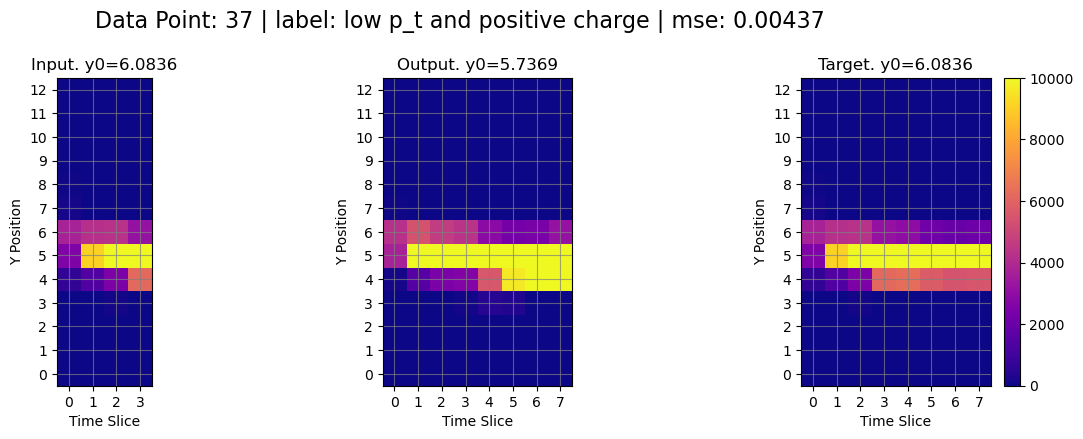

target datapoint  [0. 0. 1.]
input_datapoint_reshaped shape (1, 105, 1)
1/1 [==============================] - 0s 25ms/step
predictions datapoint  [ 1.58041716e-03  2.41747824e-03  5.86442975e-03 -6.19252026e-03
 -1.43647045e-02  3.73791814e-01  3.19166720e-01  6.79552615e-01
 -4.70913559e-01 -2.28672028e-02  2.15059309e-03  2.03293259e-03
  8.91520758e-04  1.96410343e-03  3.47027602e-03  1.72787793e-02
 -6.42211735e-03 -1.07674384e-02  4.56051290e-01  5.77200770e-01
  7.12225437e-01 -5.11657715e-01  3.26204300e-03  2.54902127e-03
  1.34534447e-03  1.16412144e-03  2.29803845e-03  4.63941135e-03
 -1.34247914e-03 -6.79394603e-03  2.63991773e-01  4.82806504e-01
  6.69291615e-01  6.81411505e-01 -4.62141603e-01 -1.35545731e-02
  2.05911673e-03  1.23300252e-03  1.11100473e-03  2.80705886e-03
  1.12685841e-02 -1.38916075e-03 -6.57165051e-03  4.07999039e-01
  5.75374901e-01  6.93216562e-01  6.77839041e-01 -4.15649235e-01
 -8.99791718e-03  2.07849639e-03  1.20454037e-03  1.29198283e-03
  3.4730

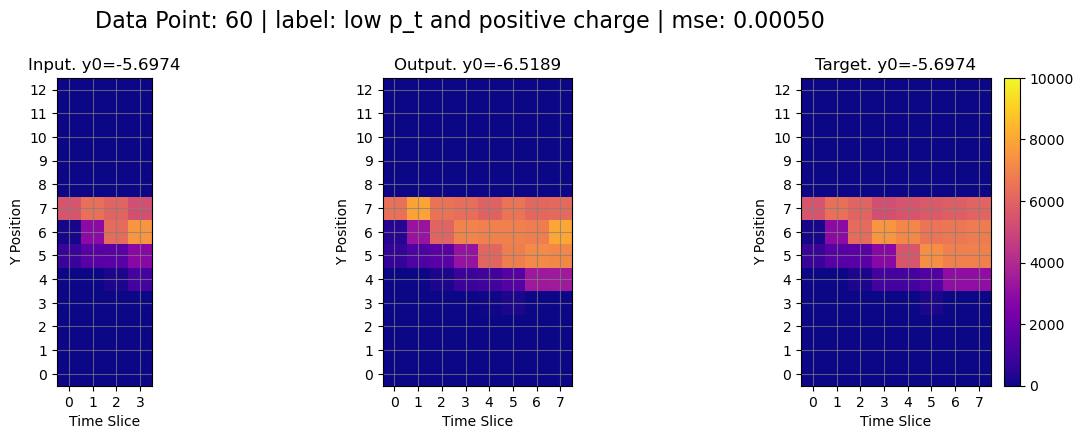

target datapoint  [1. 0. 0.]
input_datapoint_reshaped shape (1, 105, 1)
1/1 [==============================] - 0s 22ms/step
predictions datapoint  [ 1.5804172e-03  2.4174782e-03  5.8644298e-03 -6.1925203e-03
  1.8570639e-01  4.2187959e-01  3.1028736e-01  6.9356781e-01
 -4.4684279e-01 -2.2867203e-02  2.1505931e-03  2.0329326e-03
  8.9152076e-04  1.9641034e-03  3.4702760e-03  1.7278779e-02
 -6.4221174e-03  3.8039666e-01  4.6434498e-01  5.2913392e-01
  6.8261051e-01 -4.6721771e-01  3.2620430e-03  2.5490213e-03
  1.3453445e-03  1.1641214e-03  2.2980385e-03  4.6394113e-03
 -1.3424791e-03  9.5215179e-02  4.6145329e-01  5.3419644e-01
  5.9286511e-01  7.0802569e-01 -4.3786532e-01 -1.3554573e-02
  2.0591167e-03  1.2330025e-03  1.1110047e-03  2.8070589e-03
  1.1268584e-02 -1.3891608e-03  3.4802821e-01  4.6331668e-01
  6.6318005e-01  6.0188329e-01  7.0735788e-01 -3.8063768e-01
 -8.9979172e-03  2.0784964e-03  1.2045404e-03  1.2919828e-03
  3.4730940e-03  2.6258672e-02 -2.6378781e-04  3.9399257e-01

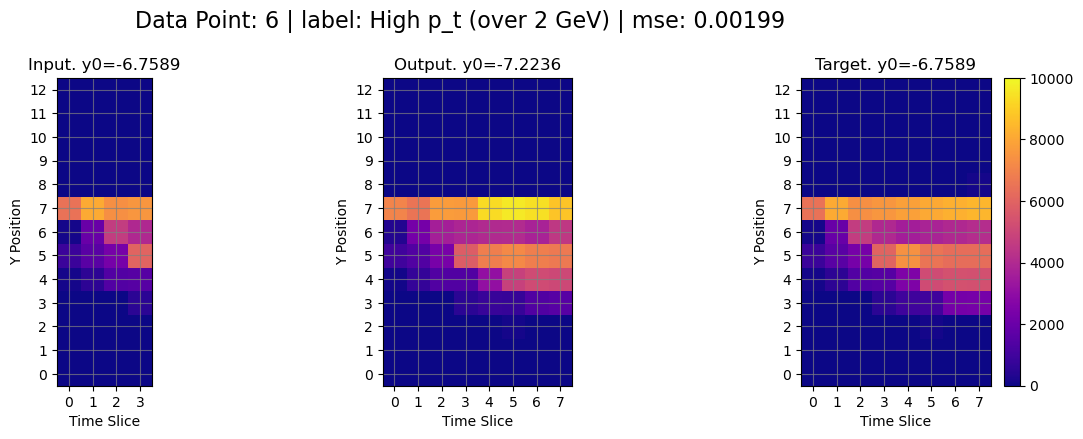

target datapoint  [0. 0. 1.]
input_datapoint_reshaped shape (1, 105, 1)
1/1 [==============================] - 0s 20ms/step
predictions datapoint  [ 1.5804172e-03  2.4174782e-03  5.8644298e-03  3.4861135e-01
  4.8208034e-01  4.0767187e-01  6.6165566e-01 -5.0918549e-01
 -7.5513124e-03 -2.2867203e-02  2.1505931e-03  2.0329326e-03
  8.9152076e-04  1.9641034e-03  3.4702760e-03  1.7278779e-02
  4.6401495e-01  4.9349412e-01  6.3614333e-01  6.4081860e-01
 -4.2647019e-01 -8.8505745e-03  3.2620430e-03  2.5490213e-03
  1.3453445e-03  1.1641214e-03  2.2980385e-03  4.6394113e-03
  3.8932687e-01  5.3834283e-01  5.8084863e-01  6.6909510e-01
  6.4189339e-01 -3.8035721e-01 -7.2807670e-03 -1.3554573e-02
  2.0591167e-03  1.2330025e-03  1.1110047e-03  2.8070589e-03
  1.1268584e-02  4.8531550e-01  5.9090483e-01  6.8063587e-01
  6.4876419e-01  6.6132236e-01 -3.3908778e-01  1.1991918e-02
 -8.9979172e-03  2.0784964e-03  1.2045404e-03  1.2919828e-03
  3.4730940e-03  2.6258672e-02  5.3974247e-01  6.6567171e-01

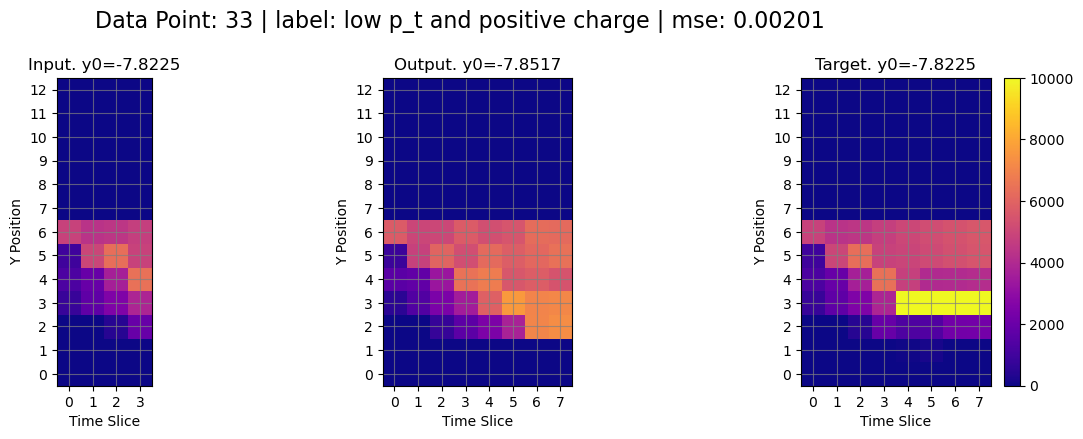

target datapoint  [1. 0. 0.]
input_datapoint_reshaped shape (1, 105, 1)
1/1 [==============================] - 0s 21ms/step
predictions datapoint  [ 1.5804172e-03  2.4174782e-03  5.8644298e-03 -6.1925203e-03
  1.0955992e-01  3.4209758e-01  6.9336760e-01 -2.9131389e-01
  1.1705339e-02 -2.2867203e-02  2.1505931e-03  2.0329326e-03
  8.9152076e-04  1.9641034e-03  3.4702760e-03  1.7278779e-02
 -6.4221174e-03  3.7614489e-01  6.6457897e-01  6.9171298e-01
 -4.2202795e-01  1.3071299e-03  3.2620430e-03  2.5490213e-03
  1.3453445e-03  1.1641214e-03  2.2980385e-03  4.6394113e-03
 -1.3424791e-03 -6.7939460e-03  4.6329015e-01  8.0527848e-01
  7.0534182e-01 -4.8261198e-01 -4.0500939e-02 -1.3554573e-02
  2.0591167e-03  1.2330025e-03  1.1110047e-03  2.8070589e-03
  1.1268584e-02 -1.3891608e-03  3.6336552e-02  4.9492675e-01
  8.3092707e-01  6.9901550e-01 -4.1583696e-01 -6.7642927e-03
 -8.9979172e-03  2.0784964e-03  1.2045404e-03  1.2919828e-03
  3.4730940e-03  2.6258672e-02 -2.6378781e-04  2.6932967e-01

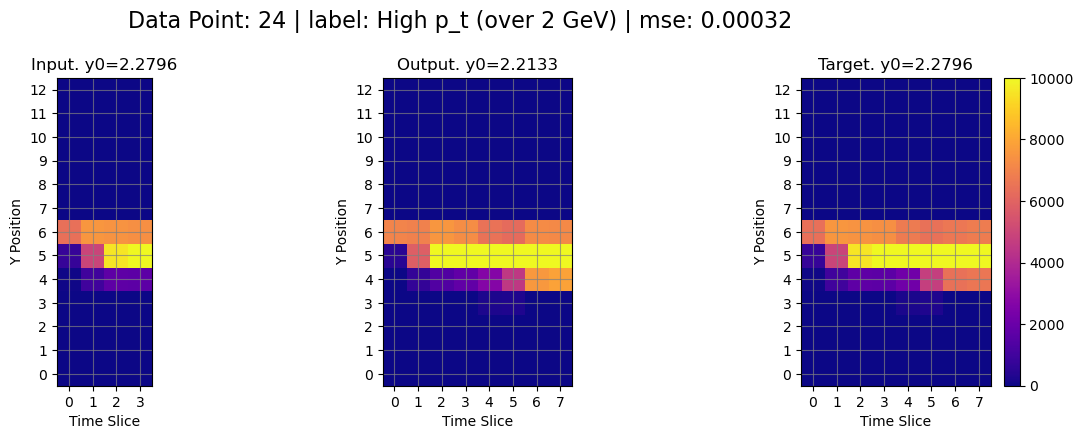

target datapoint  [1. 0. 0.]
input_datapoint_reshaped shape (1, 105, 1)
1/1 [==============================] - 0s 21ms/step
predictions datapoint  [ 1.5804172e-03  2.4174782e-03  5.8644298e-03  2.7516800e-01
  3.2381517e-01  3.5521239e-01 -2.4403730e-01  8.1003308e-03
  4.4841170e-03 -2.2867203e-02  2.1505931e-03  2.0329326e-03
  8.9152076e-04  1.9641034e-03  3.4702760e-03  1.7278779e-02
  3.1775725e-01  4.5267701e-01  3.7666863e-01 -2.8376150e-01
 -1.4953613e-03 -1.6468883e-02  3.2620430e-03  2.5490213e-03
  1.3453445e-03  1.1641214e-03  2.2980385e-03  4.6394113e-03
  3.7519917e-02  3.0576199e-01  5.0737458e-01  3.3249086e-01
 -2.1177605e-01 -9.1583729e-03 -1.8780053e-02 -1.3554573e-02
  2.0591167e-03  1.2330025e-03  1.1110047e-03  2.8070589e-03
  1.1268584e-02  2.3532274e-01  3.6583915e-01  5.4629308e-01
  2.7526486e-01 -1.4183015e-01  3.3317208e-03  5.7398677e-03
 -8.9979172e-03  2.0784964e-03  1.2045404e-03  1.2919828e-03
  3.4730940e-03  2.6258672e-02  2.7402514e-01  4.6105263e-01

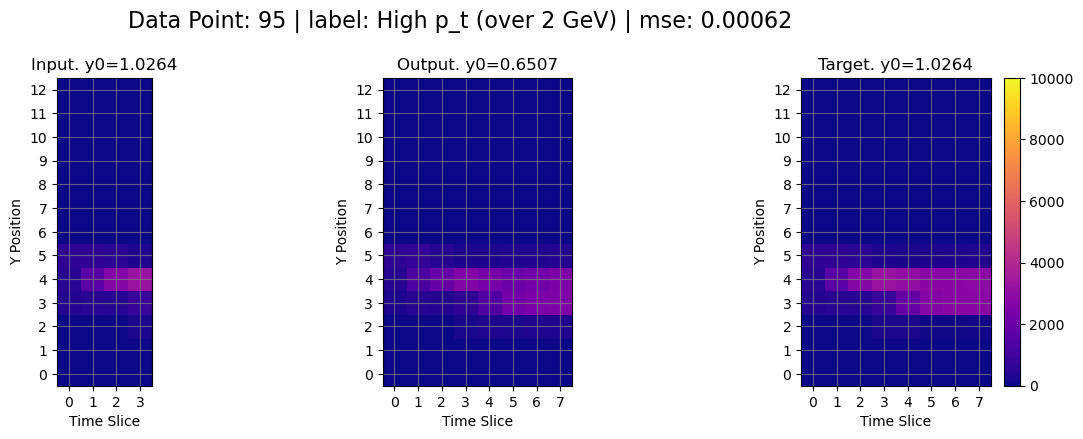

target datapoint  [1. 0. 0.]
input_datapoint_reshaped shape (1, 105, 1)
1/1 [==============================] - 0s 20ms/step
predictions datapoint  [ 1.5804172e-03  2.4174782e-03  5.8644298e-03 -6.1925203e-03
  2.8499538e-01  6.4264643e-01  2.8685391e-02  3.3582389e-02
 -1.2365460e-02 -2.2867203e-02  2.1505931e-03  2.0329326e-03
  8.9152076e-04  1.9641034e-03  3.4702760e-03  1.7278779e-02
 -6.4221174e-03  5.8618295e-01  6.7761189e-01  1.2763423e-01
 -6.0725331e-02 -5.0414801e-03  3.2620430e-03  2.5490213e-03
  1.3453445e-03  1.1641214e-03  2.2980385e-03  4.6394113e-03
 -1.3424791e-03  9.4399102e-02  7.2687829e-01  6.4211541e-01
 -4.4502974e-02 -4.4177145e-02 -1.4946938e-02 -1.3554573e-02
  2.0591167e-03  1.2330025e-03  1.1110047e-03  2.8070589e-03
  1.1268584e-02 -1.3891608e-03  1.9096799e-01  7.2805101e-01
  6.8152732e-01 -1.8097296e-01  4.4658184e-02 -1.4266759e-02
 -8.9979172e-03  2.0784964e-03  1.2045404e-03  1.2919828e-03
  3.4730940e-03  2.6258672e-02 -2.6378781e-04  1.9281246e-01

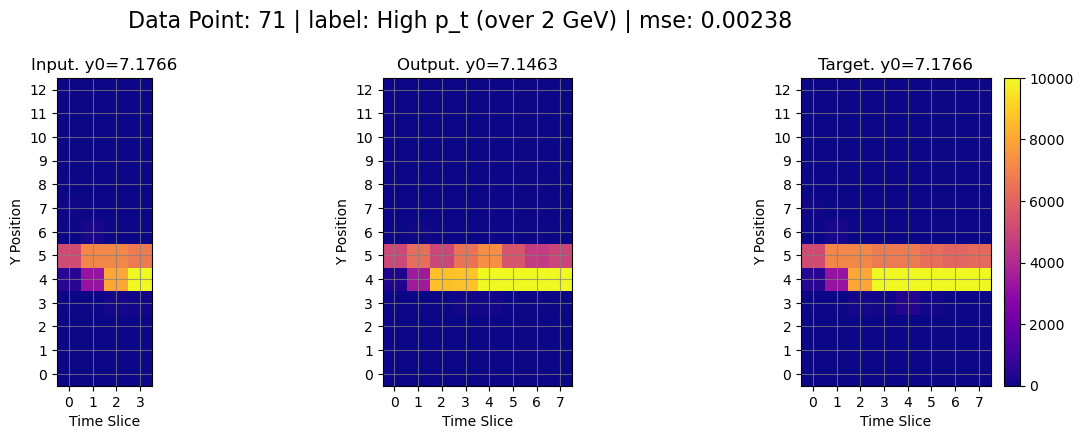

target datapoint  [0. 0. 1.]
input_datapoint_reshaped shape (1, 105, 1)
1/1 [==============================] - 0s 22ms/step
predictions datapoint  [ 1.5804172e-03  2.4174782e-03  5.8644298e-03 -6.1925203e-03
  5.7302549e-02  3.3335429e-01  5.2592862e-01  3.9924997e-01
 -1.3392282e-01 -2.2867203e-02  2.1505931e-03  2.0329326e-03
  8.9152076e-04  1.9641034e-03  3.4702760e-03  1.7278779e-02
 -6.4221174e-03  2.9110920e-01  4.2287642e-01  6.4788735e-01
  9.7714782e-02 -7.3606074e-02  3.2620430e-03  2.5490213e-03
  1.3453445e-03  1.1641214e-03  2.2980385e-03  4.6394113e-03
 -1.3424791e-03 -6.7939460e-03  4.1461360e-01  5.6246096e-01
  6.6496563e-01 -2.0246193e-01 -6.2221825e-02 -1.3554573e-02
  2.0591167e-03  1.2330025e-03  1.1110047e-03  2.8070589e-03
  1.1268584e-02 -1.3891608e-03  2.0230223e-01  4.4882870e-01
  6.4876419e-01  6.8016899e-01 -1.3245535e-01 -4.3026239e-02
 -8.9979172e-03  2.0784964e-03  1.2045404e-03  1.2919828e-03
  3.4730940e-03  2.6258672e-02 -2.6378781e-04  3.0371943e-01

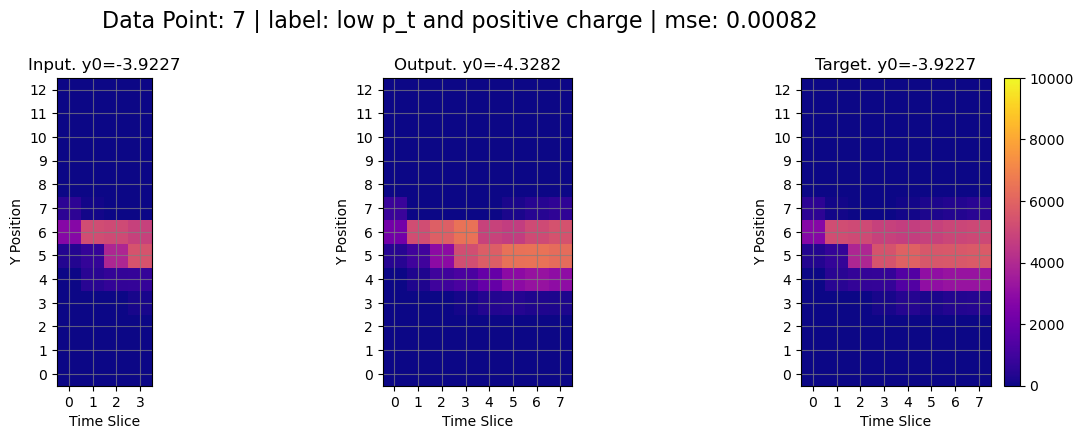

target datapoint  [1. 0. 0.]
input_datapoint_reshaped shape (1, 105, 1)
1/1 [==============================] - 0s 22ms/step
predictions datapoint  [ 1.5804172e-03  2.4174782e-03  5.8644298e-03 -6.1925203e-03
  1.2971634e-01  3.9018536e-01  4.3206120e-01  5.0627464e-01
  2.9212976e-01 -2.2867203e-02  2.1505931e-03  2.0329326e-03
  8.9152076e-04  1.9641034e-03  3.4702760e-03  1.7278779e-02
 -6.4221174e-03  3.2852492e-01  4.7500837e-01  4.9944556e-01
  6.1005378e-01  4.7745031e-01  3.2620430e-03  2.5490213e-03
  1.3453445e-03  1.1641214e-03  2.2980385e-03  4.6394113e-03
 -1.3424791e-03 -6.7939460e-03  4.5410588e-01  5.9329492e-01
  5.7411897e-01  6.8561375e-01  6.1112559e-01 -1.3554573e-02
  2.0591167e-03  1.2330025e-03  1.1110047e-03  2.8070589e-03
  1.1268584e-02 -1.3891608e-03  1.6425157e-01  5.1600009e-01
  7.1429044e-01  6.5117431e-01  6.9555032e-01  6.6095608e-01
 -8.9979172e-03  2.0784964e-03  1.2045404e-03  1.2919828e-03
  3.4730940e-03  2.6258672e-02 -2.6378781e-04  3.3896896e-01

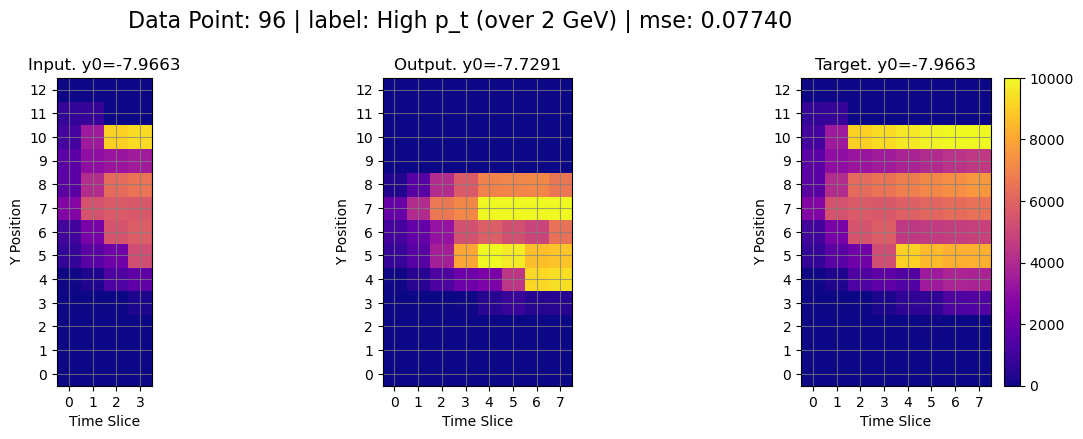

target datapoint  [1. 0. 0.]
input_datapoint_reshaped shape (1, 105, 1)
1/1 [==============================] - 0s 28ms/step
predictions datapoint  [ 1.5804172e-03  2.4174782e-03  5.8644298e-03  4.4688064e-01
  3.3575970e-01  6.2515986e-01 -4.0132850e-01 -2.2478133e-02
  8.0947280e-03 -2.2867203e-02  2.1505931e-03  2.0329326e-03
  8.9152076e-04  1.9641034e-03  3.4702760e-03  1.7278779e-02
  5.1000321e-01  5.5642056e-01  6.8946010e-01 -4.5623672e-01
 -1.9264340e-02 -1.2323260e-03  3.2620430e-03  2.5490213e-03
  1.3453445e-03  1.1641214e-03  2.2980385e-03  4.6394113e-03
  5.3591311e-01  5.7506609e-01  6.8463075e-01  6.5753239e-01
 -4.2663541e-01 -1.1959910e-02  9.3293190e-03 -1.3554573e-02
  2.0591167e-03  1.2330025e-03  1.1110047e-03  2.8070589e-03
  1.1268584e-02  5.8453143e-01  6.6943491e-01  6.9248968e-01
  6.5269583e-01 -3.9843303e-01 -3.2091022e-02  1.1991918e-02
 -8.9979172e-03  2.0784964e-03  1.2045404e-03  1.2919828e-03
  3.4730940e-03  2.6258672e-02  5.9273010e-01  7.5250590e-01

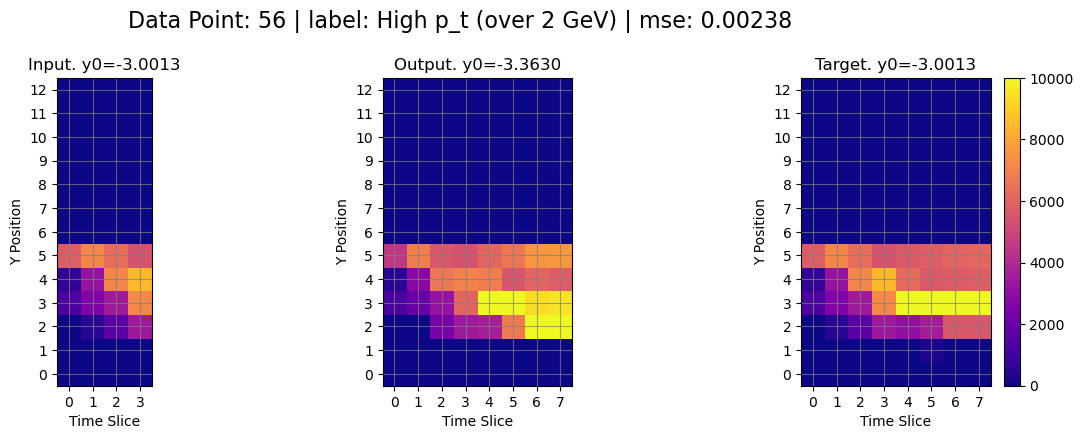

target datapoint  [1. 0. 0.]
input_datapoint_reshaped shape (1, 105, 1)
1/1 [==============================] - 0s 19ms/step
predictions datapoint  [ 1.58041716e-03  2.41747824e-03  5.86442975e-03 -6.19252026e-03
 -1.43647045e-02  9.72868800e-02  3.03945005e-01  3.15159202e-01
  5.58111787e-01 -2.28672028e-02  2.15059309e-03  2.03293259e-03
  8.91520758e-04  1.96410343e-03  3.47027602e-03  1.72787793e-02
 -6.42211735e-03 -1.33185089e-02  3.26906323e-01  3.25556636e-01
  5.24170399e-01  5.51093757e-01 -3.11087012e-01  2.54902127e-03
  1.34534447e-03  1.16412144e-03  2.29803845e-03  4.63941135e-03
 -1.34247914e-03 -6.79394603e-03  3.25485319e-02  4.09575820e-01
  4.35686111e-01  5.87561250e-01  4.79522586e-01 -1.35545731e-02
  2.05911673e-03  1.23300252e-03  1.11100473e-03  2.80705886e-03
  1.12685841e-02 -1.38916075e-03 -6.57165051e-03  2.52582848e-01
  4.10248876e-01  5.42444229e-01  5.83378434e-01  4.88399148e-01
 -8.99791718e-03  2.07849639e-03  1.20454037e-03  1.29198283e-03
  3.4730

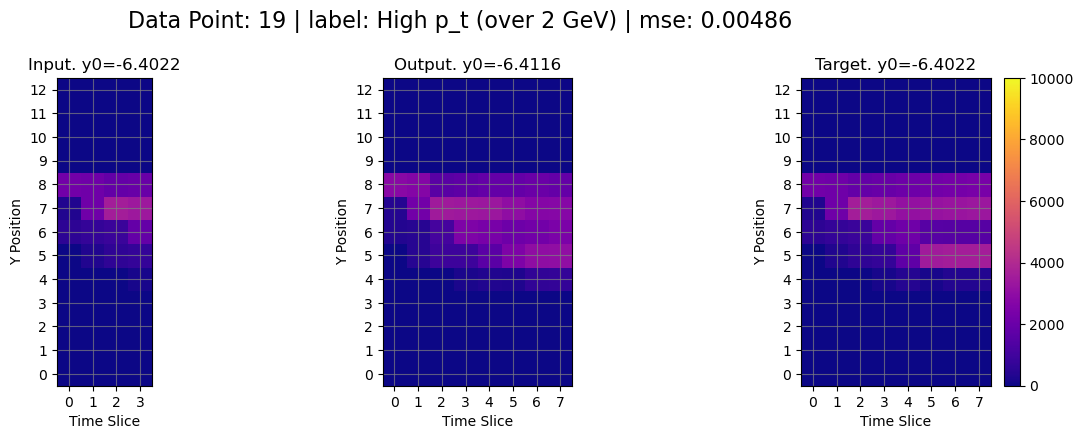

target datapoint  [0. 0. 1.]
input_datapoint_reshaped shape (1, 105, 1)
1/1 [==============================] - 0s 20ms/step
predictions datapoint  [ 1.58041716e-03  2.41747824e-03  5.86442975e-03 -6.19252026e-03
 -1.43647045e-02  3.73791814e-01  3.19166720e-01  6.79552615e-01
 -4.70913559e-01 -2.28672028e-02  2.15059309e-03  2.03293259e-03
  8.91520758e-04  1.96410343e-03  3.47027602e-03  1.72787793e-02
 -6.42211735e-03 -1.07674384e-02  4.56051290e-01  5.77200770e-01
  7.12225437e-01 -5.11657715e-01  3.26204300e-03  2.54902127e-03
  1.34534447e-03  1.16412144e-03  2.29803845e-03  4.63941135e-03
 -1.34247914e-03 -6.79394603e-03  2.63991773e-01  4.82806504e-01
  6.69291615e-01  6.81411505e-01 -4.62141603e-01 -1.35545731e-02
  2.05911673e-03  1.23300252e-03  1.11100473e-03  2.80705886e-03
  1.12685841e-02 -1.38916075e-03 -6.57165051e-03  4.07999039e-01
  5.75374901e-01  6.93216562e-01  6.77839041e-01 -4.15649235e-01
 -8.99791718e-03  2.07849639e-03  1.20454037e-03  1.29198283e-03
  3.4730

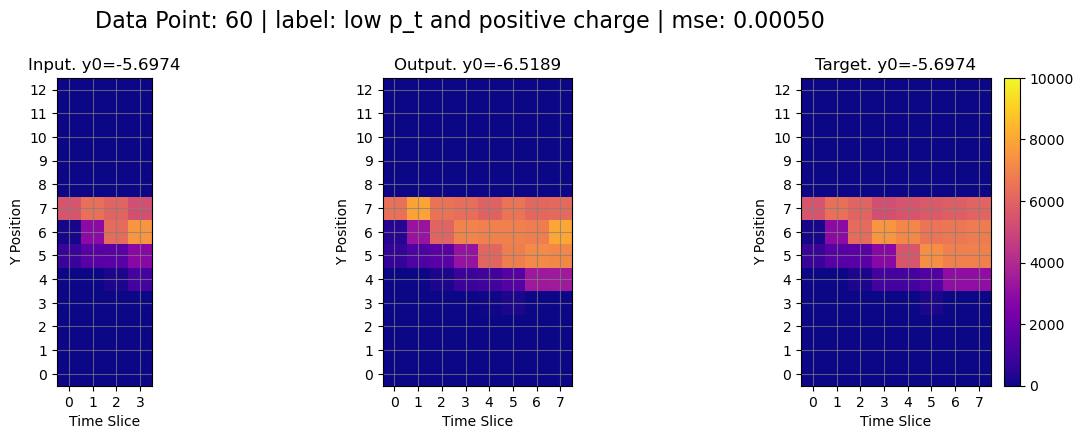

target datapoint  [0. 1. 0.]
input_datapoint_reshaped shape (1, 105, 1)
1/1 [==============================] - 0s 19ms/step
predictions datapoint  [ 1.5804172e-03  2.4174782e-03  5.8644298e-03  2.0224182e-01
  3.4471810e-01  4.9073261e-01  4.1049713e-01 -3.1042543e-01
  2.4944246e-02 -2.2867203e-02  2.1505931e-03  2.0329326e-03
  8.9152076e-04  1.9641034e-03  3.4702760e-03  1.7278779e-02
  4.0370250e-01  3.4042990e-01  6.4562184e-01  3.9845705e-04
 -1.8658891e-01  7.6556802e-03  3.2620430e-03  2.5490213e-03
  1.3453445e-03  1.1641214e-03  2.2980385e-03  4.6394113e-03
  1.9092411e-01  4.7224090e-01  5.2115095e-01  6.3055259e-01
 -1.2092945e-01 -1.1281392e-01 -4.7253370e-03 -1.3554573e-02
  2.0591167e-03  1.2330025e-03  1.1110047e-03  2.8070589e-03
  1.1268584e-02  3.6422527e-01  4.7108570e-01  6.0292780e-01
  6.2255377e-01  1.3651878e-01 -4.0946692e-02 -1.7626286e-03
 -8.9979172e-03  2.0784964e-03  1.2045404e-03  1.2919828e-03
  3.4730940e-03  2.6258672e-02  4.1740343e-01  5.6336212e-01

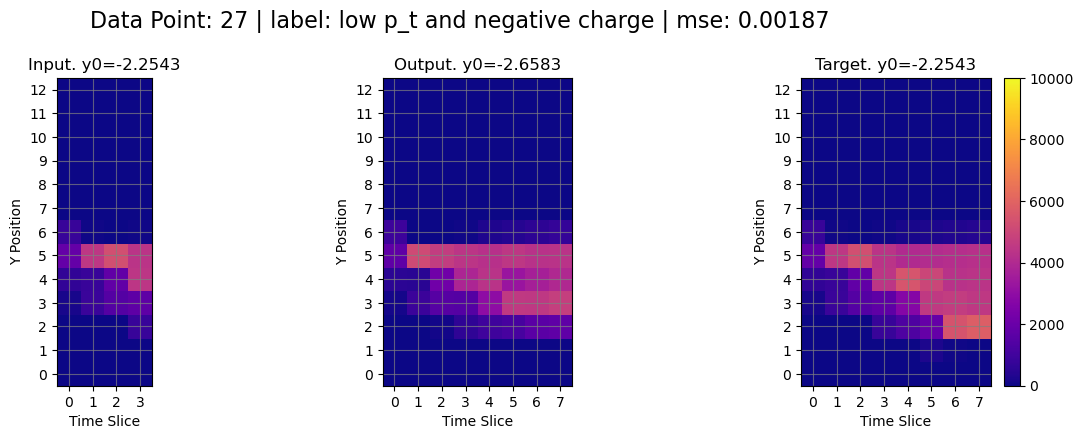

target datapoint  [0. 0. 1.]
input_datapoint_reshaped shape (1, 105, 1)
1/1 [==============================] - 0s 20ms/step
predictions datapoint  [ 1.58041716e-03  2.41747824e-03  5.86442975e-03 -6.19252026e-03
  1.47633150e-01  4.53573823e-01  1.04794025e-01 -1.12939447e-01
  3.21654677e-02 -2.28672028e-02  2.15059309e-03  2.03293259e-03
  8.91520758e-04  1.96410343e-03  3.47027602e-03  1.72787793e-02
 -6.42211735e-03  1.21037856e-01  5.91120303e-01 -2.92899013e-02
 -9.77440178e-02 -1.77385807e-02  3.26204300e-03  2.54902127e-03
  1.34534447e-03  1.16412144e-03  2.29803845e-03  4.63941135e-03
 -1.34247914e-03 -6.79394603e-03  1.90517738e-01  5.95864415e-01
 -1.09393388e-01 -2.87688971e-02 -1.87800527e-02 -1.35545731e-02
  2.05911673e-03  1.23300252e-03  1.11100473e-03  2.80705886e-03
  1.12685841e-02 -1.38916075e-03  6.46721572e-02  2.86827087e-01
  6.17311656e-01 -1.40380412e-01 -6.01339936e-02 -2.55204737e-02
 -8.99791718e-03  2.07849639e-03  1.20454037e-03  1.29198283e-03
  3.4730

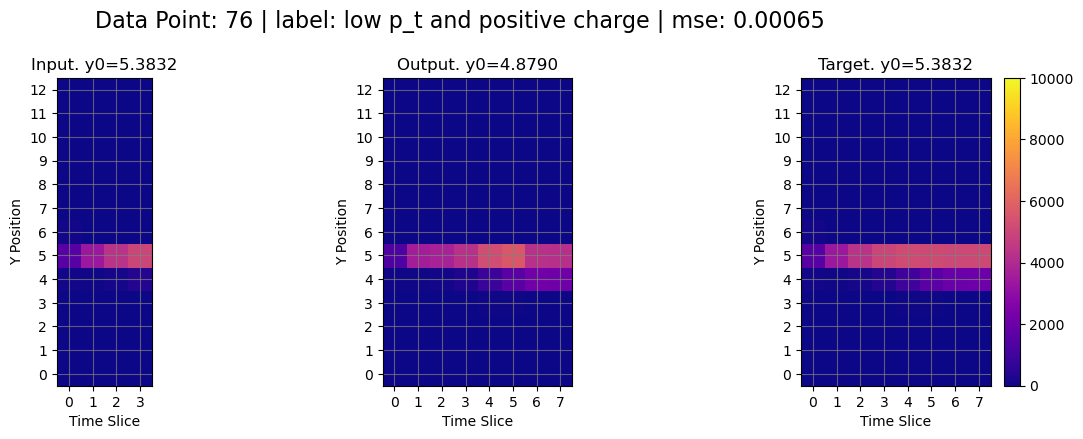

target datapoint  [1. 0. 0.]
input_datapoint_reshaped shape (1, 105, 1)
1/1 [==============================] - 0s 20ms/step
predictions datapoint  [ 1.58041716e-03  2.41747824e-03  5.86442975e-03 -6.19252026e-03
 -1.43647045e-02  2.68872917e-01  3.91469955e-01  4.26006138e-01
 -2.44648367e-01 -2.28672028e-02  2.15059309e-03  2.03293259e-03
  8.91520758e-04  1.96410343e-03  3.47027602e-03  1.72787793e-02
 -6.42211735e-03  1.84814617e-01  3.24536681e-01  5.14996529e-01
  4.19037223e-01 -2.05656439e-01  3.26204300e-03  2.54902127e-03
  1.34534447e-03  1.16412144e-03  2.29803845e-03  4.63941135e-03
 -1.34247914e-03 -6.79394603e-03  3.43894809e-01  4.10860538e-01
  5.51046848e-01  3.32624674e-01 -1.69548512e-01 -1.35545731e-02
  2.05911673e-03  1.23300252e-03  1.11100473e-03  2.80705886e-03
  1.12685841e-02 -1.38916075e-03  7.92447552e-02  3.73754799e-01
  4.96743441e-01  5.65639973e-01  3.85601699e-01 -1.11798942e-01
 -8.99791718e-03  2.07849639e-03  1.20454037e-03  1.29198283e-03
  3.4730

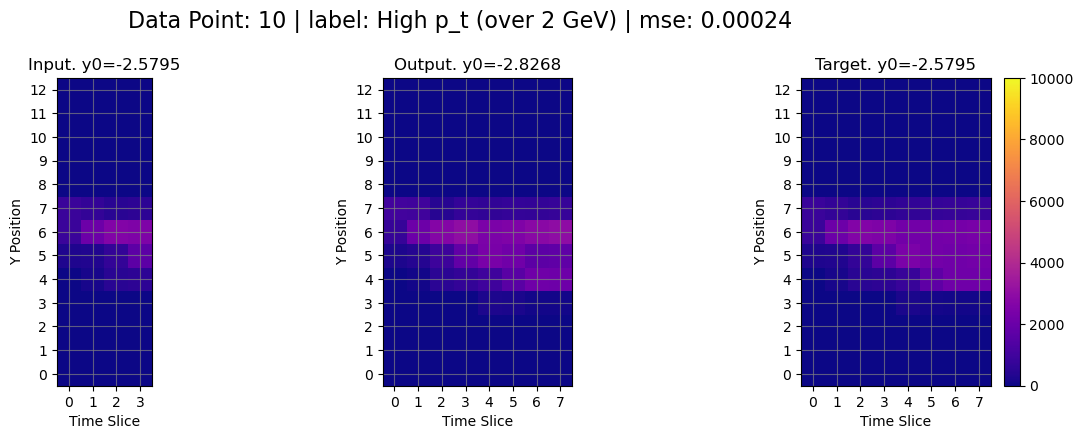

target datapoint  [0. 1. 0.]
input_datapoint_reshaped shape (1, 105, 1)
1/1 [==============================] - 0s 19ms/step
predictions datapoint  [ 1.5804172e-03  2.4174782e-03  5.8644298e-03  2.0689668e-01
  4.9029219e-01  5.3663462e-01 -1.8949276e-01  1.9567251e-02
  5.0218523e-02 -2.2867203e-02  2.1505931e-03  2.0329326e-03
  8.9152076e-04  1.9641034e-03  3.4702760e-03  1.7278779e-02
  2.9438621e-01  6.9332802e-01  5.1173764e-01 -2.8234777e-01
 -3.1110346e-02  8.9254379e-03  3.2620430e-03  2.5490213e-03
  1.3453445e-03  1.1641214e-03  2.2980385e-03  4.6394113e-03
 -1.3424791e-03  3.5635853e-01  7.4432838e-01  5.1235574e-01
 -3.4155685e-01  2.0475984e-03  2.9408336e-03 -1.3554573e-02
  2.0591167e-03  1.2330025e-03  1.1110047e-03  2.8070589e-03
  1.1268584e-02 -1.3891608e-03  3.8445970e-01  7.7283198e-01
  5.4654336e-01 -3.3029556e-01 -2.5721192e-03 -5.1224232e-04
 -8.9979172e-03  2.0784964e-03  1.2045404e-03  1.2919828e-03
  3.4730940e-03  2.6258672e-02 -2.6378781e-04  4.0259001e-01

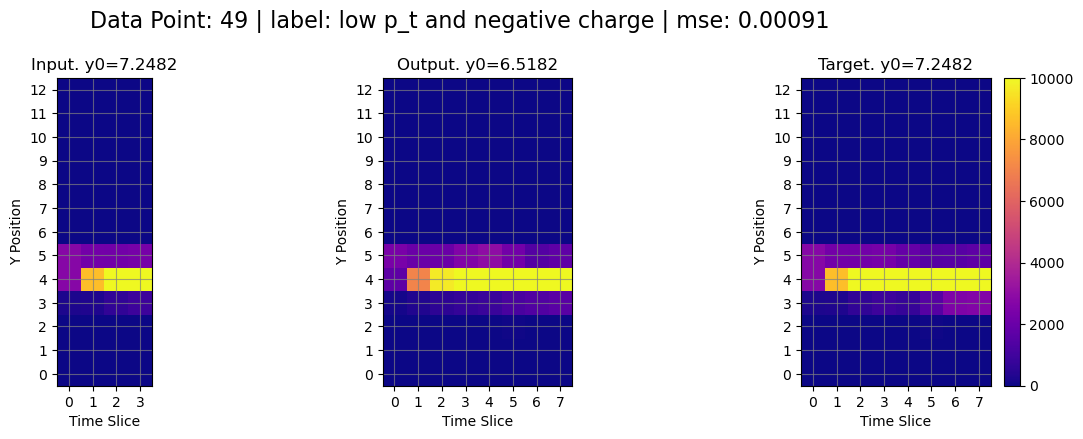

target datapoint  [1. 0. 0.]
input_datapoint_reshaped shape (1, 105, 1)
1/1 [==============================] - 0s 19ms/step
predictions datapoint  [ 1.5804172e-03  2.4174782e-03  5.8644298e-03  1.6862337e-01
  3.6412799e-01  3.8909245e-01  6.0203719e-01 -4.6459189e-01
  3.3369005e-02 -2.2867203e-02  2.1505931e-03  2.0329326e-03
  8.9152076e-04  1.9641034e-03  3.4702760e-03  1.7278779e-02
  3.2001901e-01  3.9230168e-01  6.0770774e-01  6.1537147e-01
 -4.2054719e-01  2.4161994e-02  3.2620430e-03  2.5490213e-03
  1.3453445e-03  1.1641214e-03  2.2980385e-03  4.6394113e-03
  1.2751704e-01  3.9471397e-01  4.5686117e-01  6.6652566e-01
  5.9719110e-01 -3.8876170e-01 -6.0030222e-03 -1.3554573e-02
  2.0591167e-03  1.2330025e-03  1.1110047e-03  2.8070589e-03
  1.1268584e-02  3.1891406e-01  4.2817748e-01  5.6473231e-01
  6.5269583e-01  6.1493087e-01 -3.4056371e-01  2.1995187e-02
 -8.9979172e-03  2.0784964e-03  1.2045404e-03  1.2919828e-03
  3.4730940e-03  2.6258672e-02  3.7142885e-01  5.1435673e-01

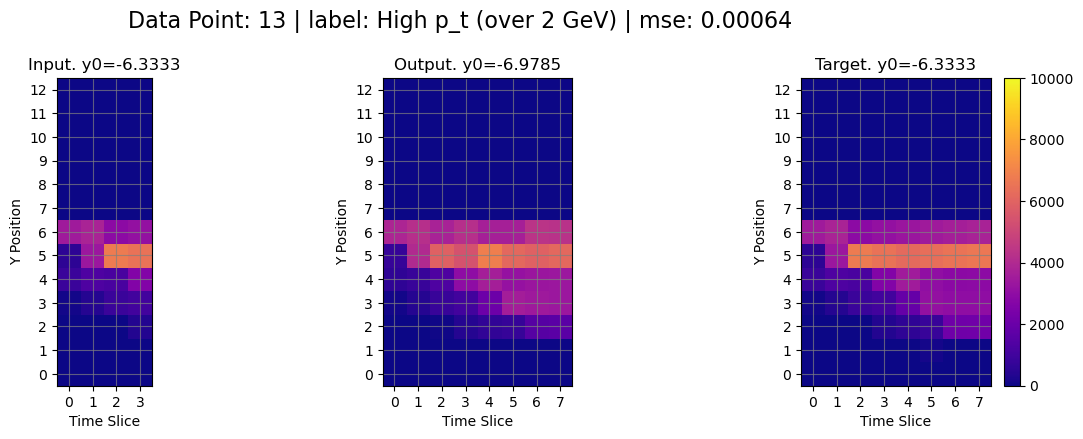

target datapoint  [1. 0. 0.]
input_datapoint_reshaped shape (1, 105, 1)
1/1 [==============================] - 0s 22ms/step
predictions datapoint  [ 1.5804172e-03  2.4174782e-03  5.8644298e-03  2.7516800e-01
  3.2381517e-01  3.5521239e-01 -2.4403730e-01  8.1003308e-03
  4.4841170e-03 -2.2867203e-02  2.1505931e-03  2.0329326e-03
  8.9152076e-04  1.9641034e-03  3.4702760e-03  1.7278779e-02
  3.1775725e-01  4.5267701e-01  3.7666863e-01 -2.8376150e-01
 -1.4953613e-03 -1.6468883e-02  3.2620430e-03  2.5490213e-03
  1.3453445e-03  1.1641214e-03  2.2980385e-03  4.6394113e-03
  3.7519917e-02  3.0576199e-01  5.0737458e-01  3.3249086e-01
 -2.1177605e-01 -9.1583729e-03 -1.8780053e-02 -1.3554573e-02
  2.0591167e-03  1.2330025e-03  1.1110047e-03  2.8070589e-03
  1.1268584e-02  2.3532274e-01  3.6583915e-01  5.4629308e-01
  2.7526486e-01 -1.4183015e-01  3.3317208e-03  5.7398677e-03
 -8.9979172e-03  2.0784964e-03  1.2045404e-03  1.2919828e-03
  3.4730940e-03  2.6258672e-02  2.7402514e-01  4.6105263e-01

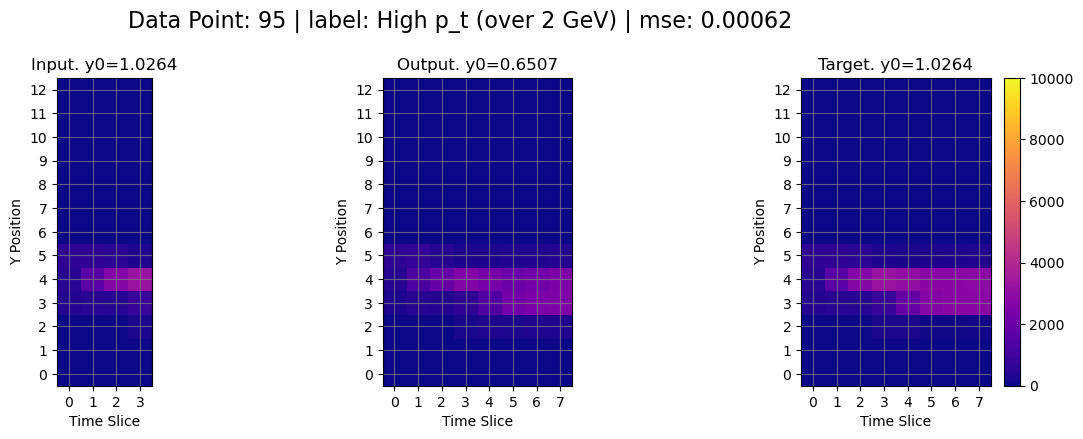

target datapoint  [0. 1. 0.]
input_datapoint_reshaped shape (1, 105, 1)
1/1 [==============================] - 0s 21ms/step
predictions datapoint  [ 1.5804172e-03  2.4174782e-03  5.8644298e-03 -6.1925203e-03
  4.4400710e-01  6.6450453e-01  6.1725891e-01 -1.8556333e-01
  2.0130098e-02 -2.2867203e-02  2.1505931e-03  2.0329326e-03
  8.9152076e-04  1.9641034e-03  3.4702760e-03  1.7278779e-02
 -6.4221174e-03  6.1084330e-01  8.4941024e-01  6.6626585e-01
 -3.9537448e-01 -4.0593445e-02  3.2620430e-03  2.5490213e-03
  1.3453445e-03  1.1641214e-03  2.2980385e-03  4.6394113e-03
 -1.3424791e-03  8.2974084e-02  6.5432268e-01  9.0420419e-01
  5.9719110e-01 -4.3358570e-01 -5.3277910e-02 -1.3554573e-02
  2.0591167e-03  1.2330025e-03  1.1110047e-03  2.8070589e-03
  1.1268584e-02 -1.3891608e-03  3.3993232e-01  7.2014850e-01
  9.1086906e-01  5.9898388e-01 -3.5679913e-01 -4.6777487e-02
 -8.9979172e-03  2.0784964e-03  1.2045404e-03  1.2919828e-03
  3.4730940e-03  2.6258672e-02 -2.6378781e-04  4.1290694e-01

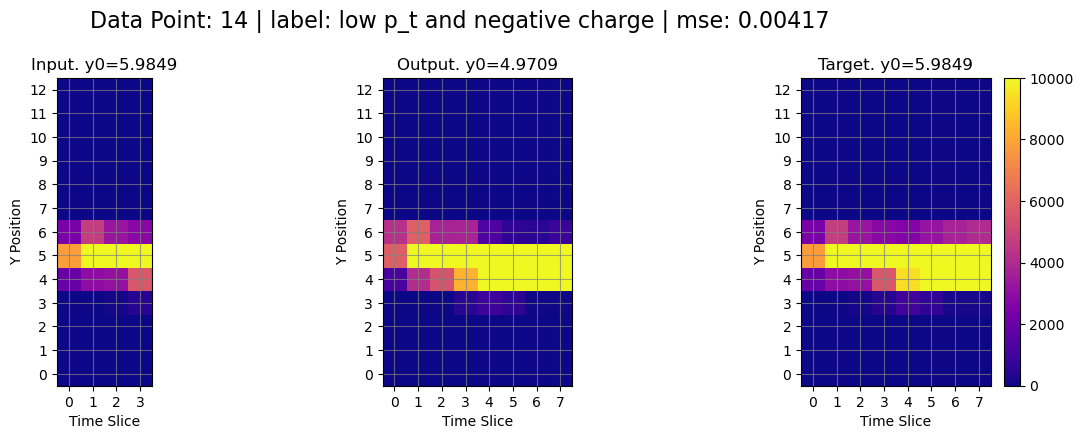

target datapoint  [1. 0. 0.]
input_datapoint_reshaped shape (1, 105, 1)
1/1 [==============================] - 0s 22ms/step
predictions datapoint  [ 1.58041716e-03  2.41747824e-03  5.86442975e-03 -6.19252026e-03
 -1.43647045e-02  3.18053663e-01  4.78994906e-01  3.11336875e-01
 -1.54382974e-01 -2.28672028e-02  2.15059309e-03  2.03293259e-03
  8.91520758e-04  1.96410343e-03  3.47027602e-03  1.72787793e-02
 -6.42211735e-03 -1.33185089e-02  3.45863402e-01  5.98406672e-01
  2.97615826e-01 -2.08195865e-01  3.26204300e-03  2.54902127e-03
  1.34534447e-03  1.16412144e-03  2.29803845e-03  4.63941135e-03
 -1.34247914e-03 -6.79394603e-03 -1.70464516e-02  4.09575820e-01
  6.21705294e-01  3.35426152e-01 -2.34711170e-01 -1.35545731e-02
  2.05911673e-03  1.23300252e-03  1.11100473e-03  2.80705886e-03
  1.12685841e-02 -1.38916075e-03 -6.57165051e-03  1.68289304e-01
  4.75775063e-01  6.67121291e-01  2.52766550e-01 -1.54312968e-01
 -8.99791718e-03  2.07849639e-03  1.20454037e-03  1.29198283e-03
  3.4730

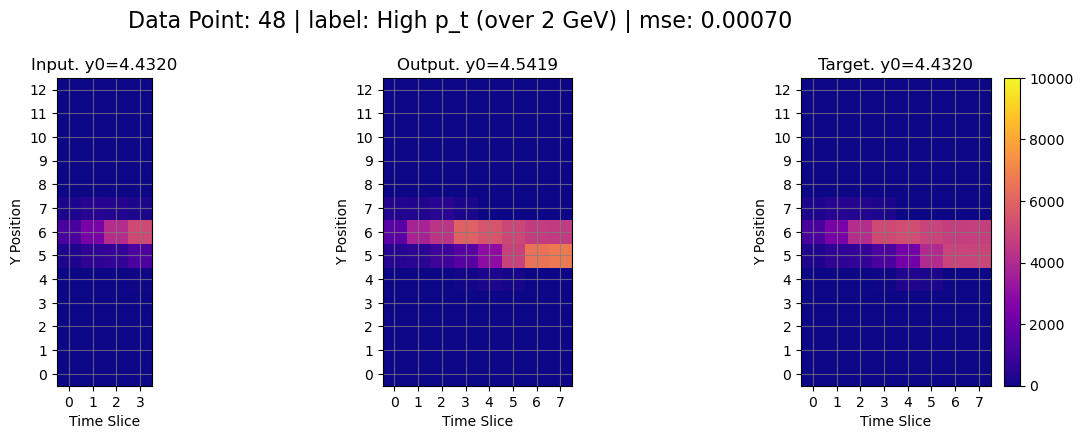

In [19]:
# DATASET DISPLAY
rand_idx = random.randint(0, 99)
input_data_combined_example = data["input_data_combined_example"]
target_data_coded_example = data["target_data_coded_example"]
input_data_example = data["input_data_example"]
target_data_example = data["target_data_example"]
# max_input_test = data["max_input_test"]
# min_input_test = data["min_input_test"]
# print(max_input_test)
# print(min_input_test)
# animation, gif = display_dataset(input_data_example, target_data_example, rand_idx, gif=False, difference=False)
for i in range(20):
    rand_idx = random.randint(0, 99)
    display_model_example(model, HYPERPARAMETERS, input_data_combined_example, target_data_coded_example, rand_idx, global_min, global_max,
                        vmin=-1, vmax=10000, unscaling=True)

1/1 [==============================] - 0s 36ms/step


/lscratch/alexyue/tmp/ipykernel_1327218/905798808.py:242: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


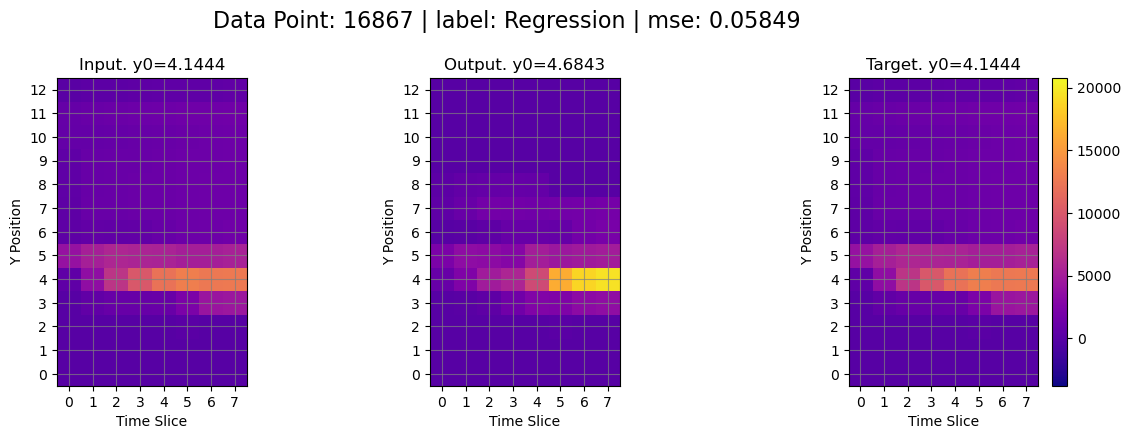

In [118]:
# ANOMALY DISPLAY
rand_idx = random.choice(anomaly_indices)

input_data_combined_example = data["input_data_combined_example"]
target_data_coded_example = data["target_data_coded_example"]
input_data_example = data["input_data_example"]
target_data_example = data["target_data_example"]

display_model_example(model, HYPERPARAMETERS, input_data_combined_example, target_data_coded_example, rand_idx, global_min, global_max,
    vmin=global_min, vmax=global_max*0.5, unscaling=True)
animation, gif = display_dataset(input_data_example, target_data_example, rand_idx, gif=False, difference=False)

# Anomaly Detection

z_mean is [ 0.002  0.003  0.006  0.069  0.198  0.341  0.28   0.127 -0.02  -0.022
  0.002  0.002  0.001  0.003  0.004  0.017  0.125  0.298  0.452  0.317
  0.123 -0.045 -0.019  0.002  0.002  0.001  0.003  0.006  0.048  0.18
  0.387  0.508  0.336  0.112 -0.053 -0.013  0.003  0.002  0.002  0.004
  0.012  0.088  0.24   0.458  0.531  0.343  0.107 -0.043 -0.009  0.003
  0.002  0.002  0.005  0.027  0.123  0.299  0.505  0.546  0.345  0.109
 -0.028 -0.006  0.003  0.002  0.002  0.007  0.042  0.148  0.337  0.529
  0.551  0.349  0.117 -0.011 -0.003  0.003  0.002  0.002  0.005  0.024
  0.117  0.309  0.52   0.554  0.362  0.132  0.004 -0.001  0.003  0.002
  0.002  0.005  0.02   0.111  0.305  0.52   0.562  0.38   0.151  0.018
  0.001  0.003  0.002  0.002 -0.004] and z_log_var is [-6.936 -6.696 -6.042 -3.78  -2.977 -2.926 -2.259 -2.166 -2.974 -4.471
 -6.423 -6.864 -7.303 -6.493 -6.211 -5.099 -3.274 -2.736 -3.05  -1.918
 -1.967 -2.951 -4.585 -6.183 -6.579 -6.976 -6.221 -5.888 -4.16  -3.053
 -2.708 -3.08 

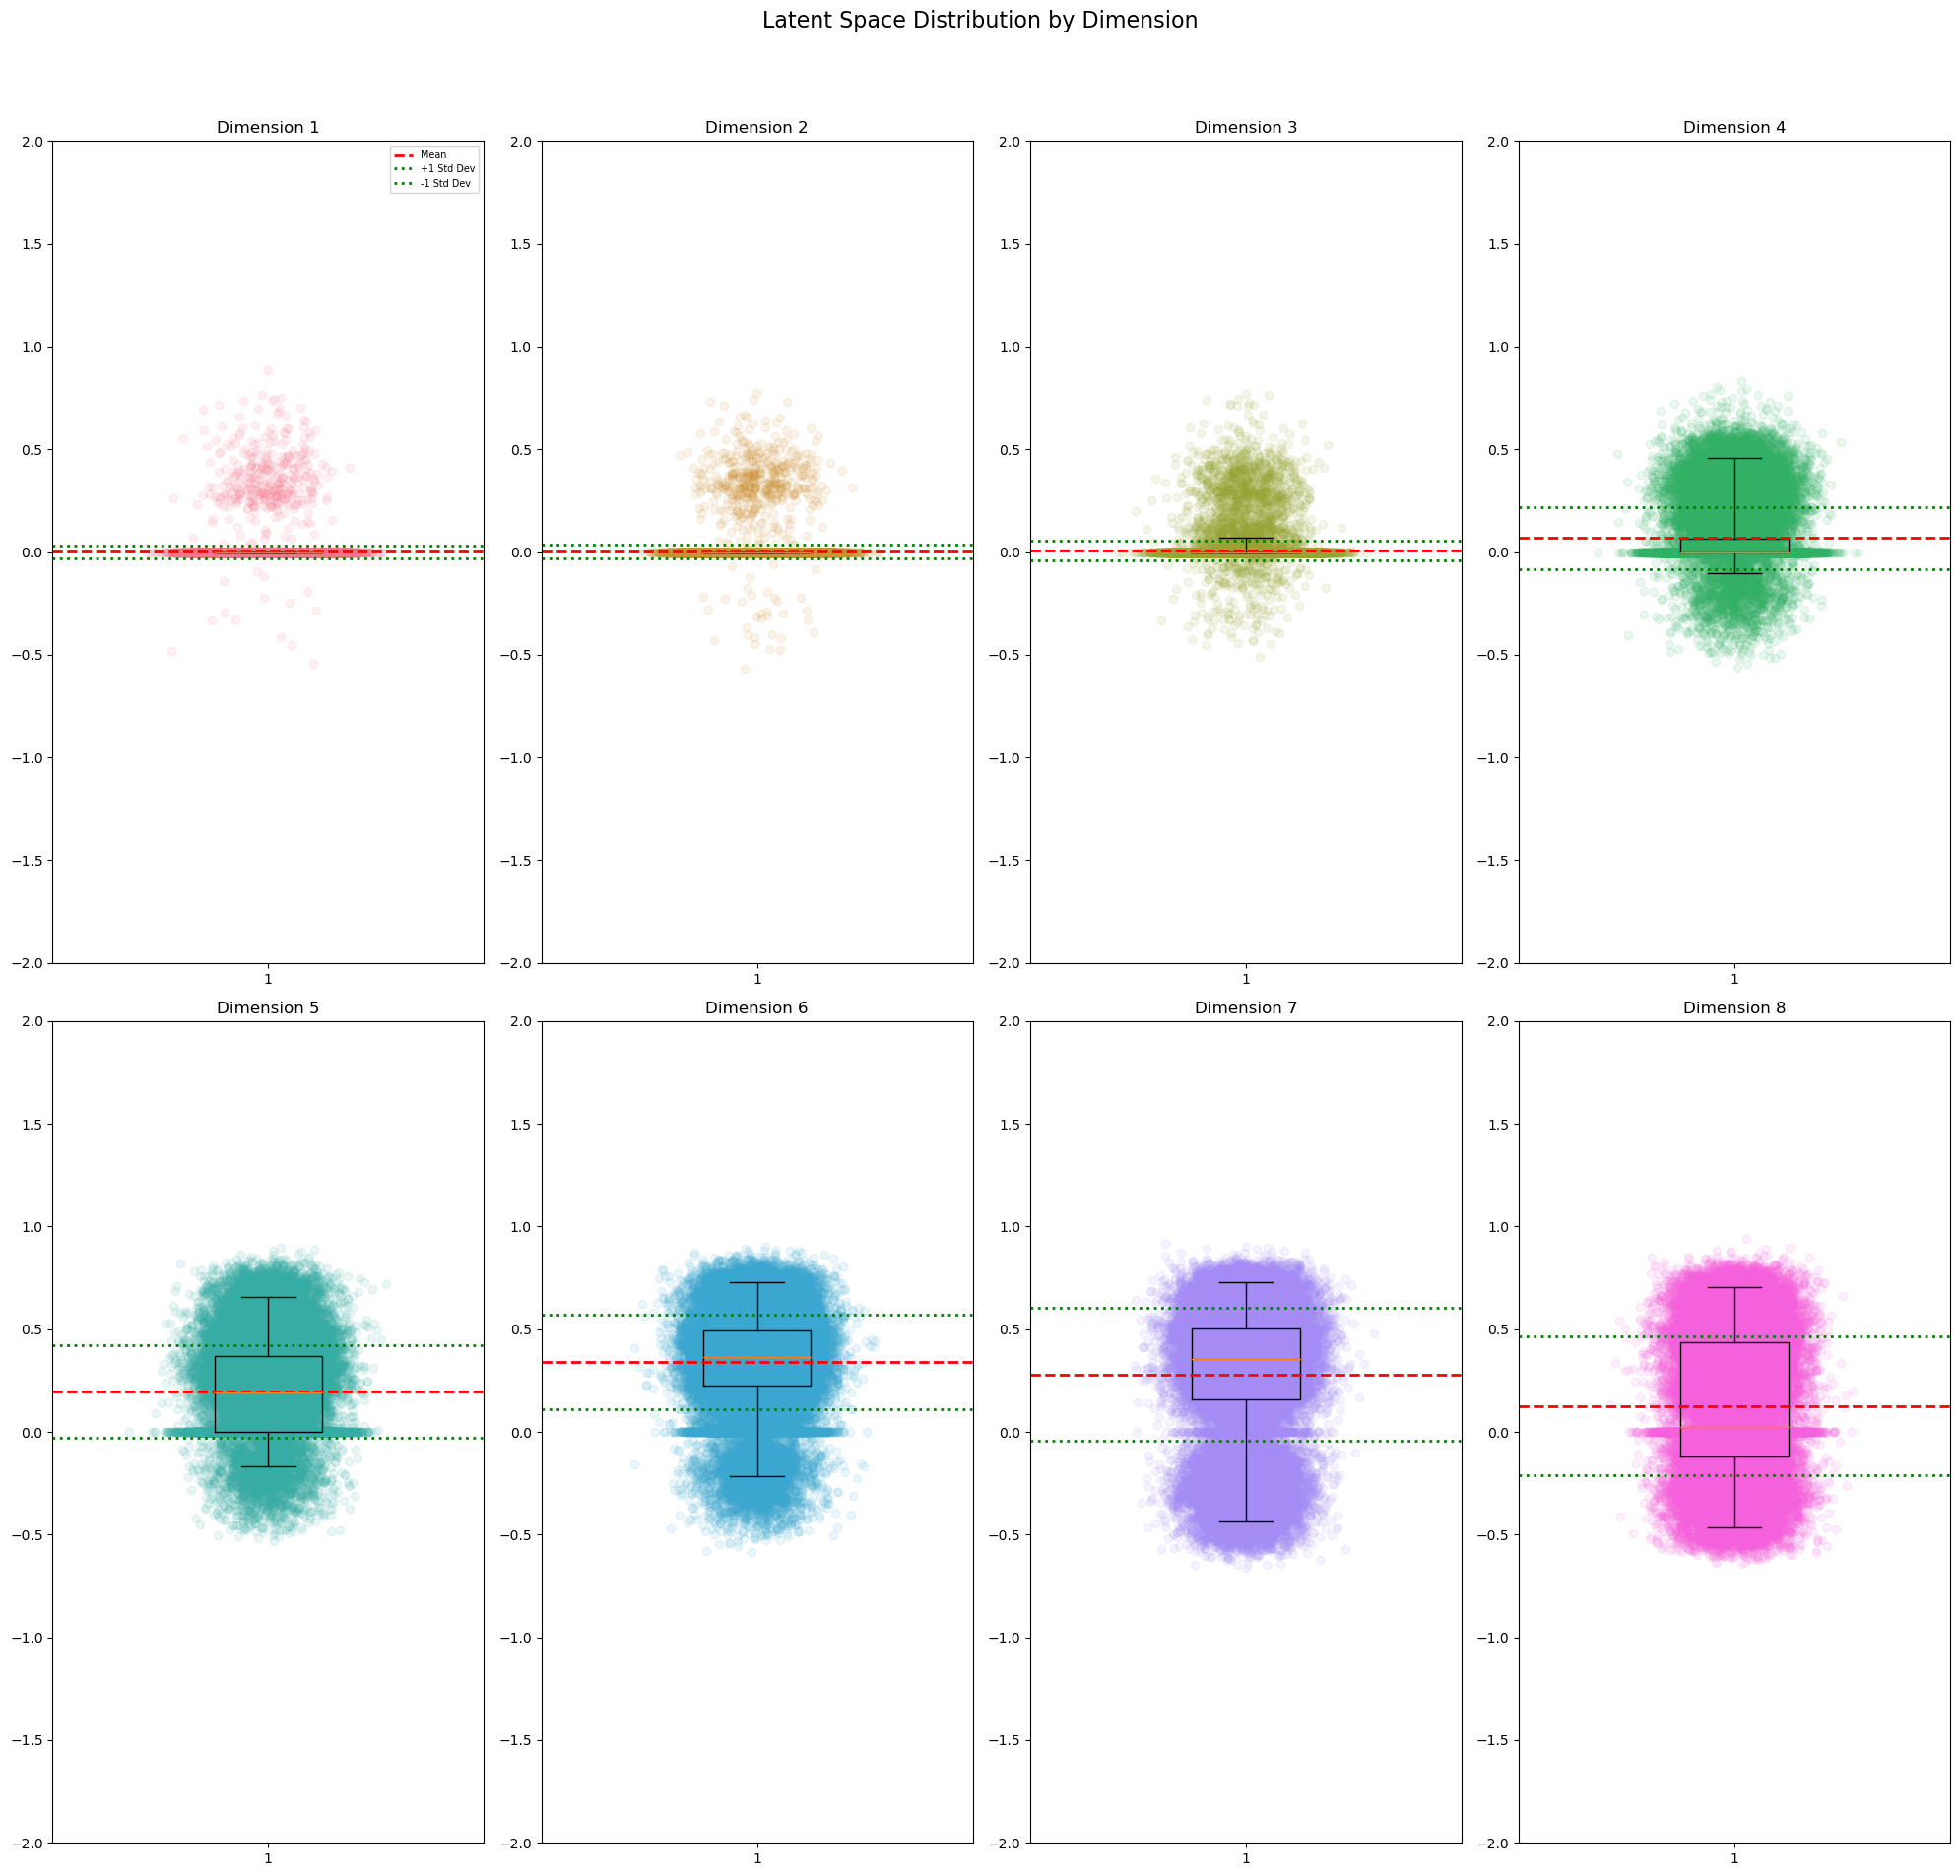

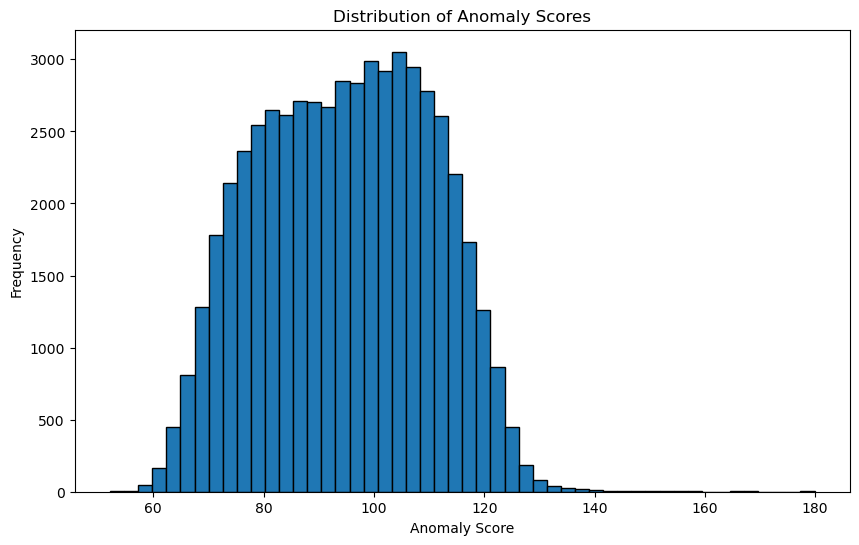

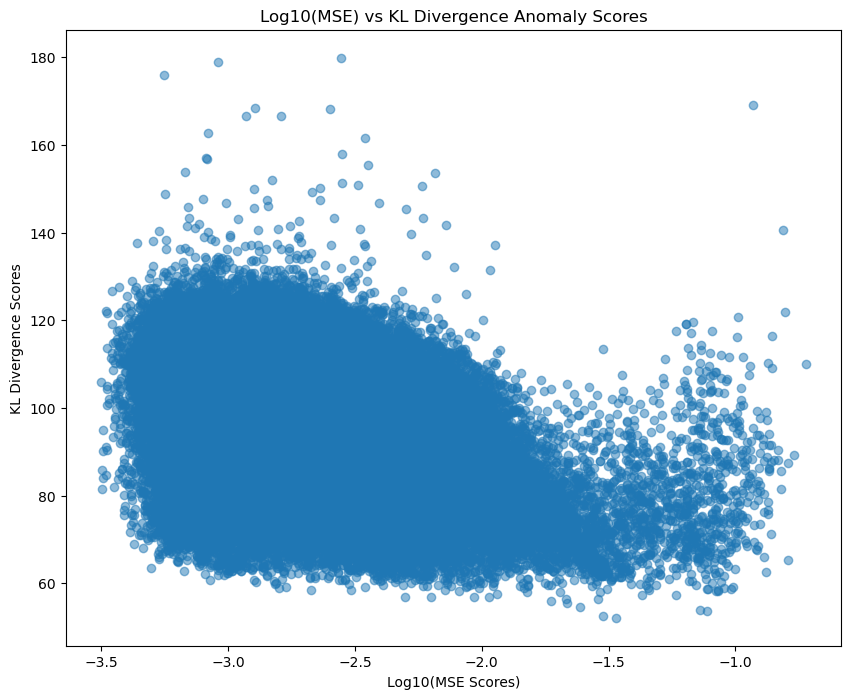

Correlation between Log10(MSE) and KL Divergence scores: -0.4143
P-value: 0.0000


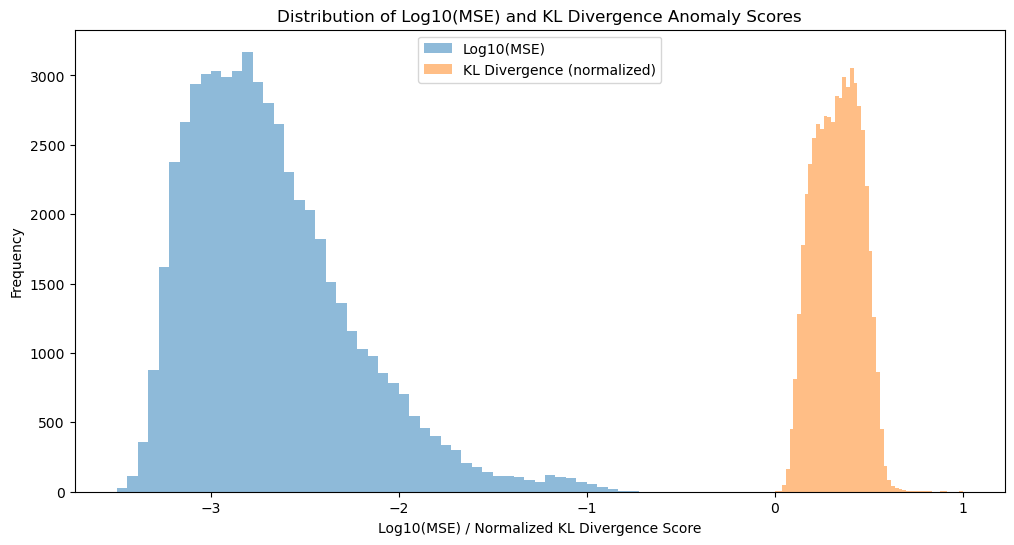

Number of common top 100 anomalies: 2


In [122]:
# # Calculate the latent stats and anomaly scores
# z_mean, z_log_var = calculate_latent_stats(data["input_test_data_encoded"])
# sample_anomaly_scores = calculate_anomaly_scores(data["input_test_data_encoded"])
# print(f"z_mean is {z_mean} and z_log_var is {z_log_var}")

# # Call the plotting functions
# plot_latent_space_boxplots(data["input_test_data_encoded"], z_mean, z_log_var, HYPERPARAMETERS)
# plot_anomaly_scores(sample_anomaly_scores)
# compare_anomaly_scores(results, sample_anomaly_scores)

# Calculate the latent stats and anomaly scores
z_mean, z_log_var = calculate_latent_stats(data["input_test_data_masked"])
sample_anomaly_scores = calculate_anomaly_scores(data["input_test_data_masked"])
print(f"z_mean is {z_mean} and z_log_var is {z_log_var}")

# Call the plotting functions
plot_latent_space_boxplots(data["input_test_data_masked"], z_mean, z_log_var, HYPERPARAMETERS)
plot_anomaly_scores(sample_anomaly_scores)
compare_anomaly_scores(results, sample_anomaly_scores)

# Dataset Saving

In [ ]:
# Write input data to file for HLS 
with open('DNN_hp_input_features.dat', 'w') as file:
    for row in input_train_data_combined:
        line = ' '.join(map(str, row))  # Convert each number to string and join with space
        file.write(line + '\n')
# Write target data to file
with open('./DNN_hp_predictions_small.dat', 'w') as file:
    for score in target_test_data_coded:
        file.write(str(score[0]) + '\n')  # Convert number to string

In [69]:
# Write to file
def write_inputs_to_file(data, file_path):
    with open(file_path, 'w') as file:
        for row in data:
            line = ' '.join(map(str, row))  # Convert each number to string and join with space
            file.write(line + '\n')
        
def write_outputs_to_file(data, file_path):
    with open(file_path, 'w') as file:
        if isinstance(data, np.ndarray):
            if data.ndim == 1:
                # Case: 1D numpy array
                for value in data:
                    file.write(f"{value}\n")
            elif data.ndim == 2:
                # Case: 2D numpy array
                np.savetxt(file, data, fmt='%g', delimiter=' ')
            else:
                raise ValueError("Numpy array must be 1D or 2D.")
        else:
            raise ValueError("Data must be a numpy array.")
        
write_inputs_to_file(data["input_test_data_combined"], './log_1_slice_test_inputs.dat')
write_outputs_to_file(data["target_test_data_coded"], './log_single1_test_outputs.dat')